In [1]:
%matplotlib inline

# Radial velocity fitting

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.7


exoplanet version: 0.2.0


In this tutorial, we will demonstrate how to fit radial velocity observations of an exoplanetary system using *exoplanet*.
We will follow [the getting started tutorial](https://radvel.readthedocs.io/en/latest/tutorials/K2-24_Fitting+MCMC.html) from [the exellent RadVel package](https://radvel.readthedocs.io) where they fit for the parameters of the two planets in [the K2-24 system](https://arxiv.org/abs/1511.04497).

First, let's download the data from RadVel:

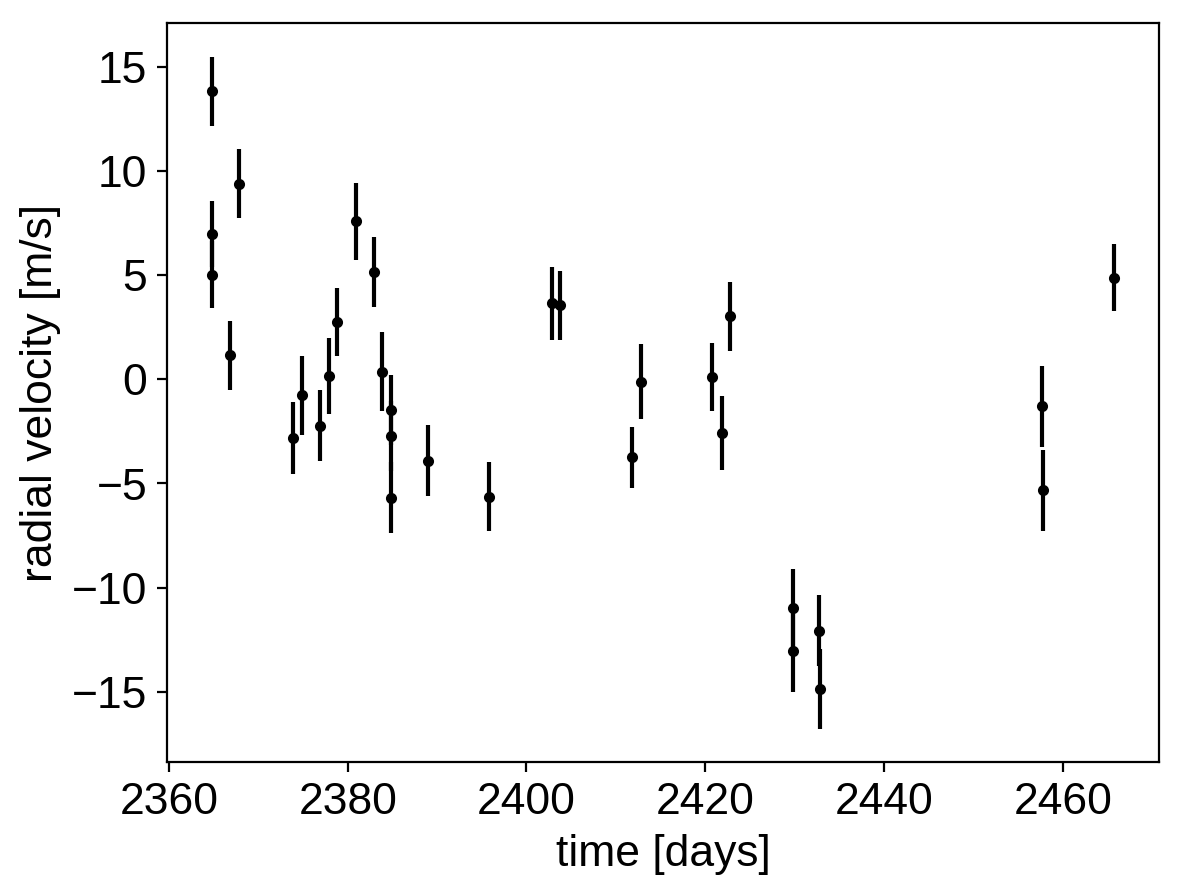

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

x = np.array(data.t)
y = np.array(data.vel)
yerr = np.array(data.errvel)

plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]");

Now, we know the periods and transit times for the planets [from the K2 light curve](https://arxiv.org/abs/1511.04497), so let's start by using the :func:`exoplanet.estimate_semi_amplitude` function to estimate the expected RV semi-amplitudes for the planets.

In [4]:
import exoplanet as xo

periods = [20.8851, 42.3633]
period_errs = [0.0003, 0.0006]
t0s = [2072.7948, 2082.6251]
t0_errs = [0.0007, 0.0004]
Ks = xo.estimate_semi_amplitude(periods, x, y, yerr, t0s=t0s)
print(Ks, "m/s")

[5.05069163 5.50983542] m/s


## The radial velocity model in PyMC3

Now that we have the data and an estimate of the initial values for the parameters, let's start defining the probabilistic model in PyMC3 (take a look at :ref:`intro-to-pymc3` if you're new to PyMC3).
First, we'll define our priors on the parameters:

In [5]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
        
    # Gaussian priors based on transit data (from Petigura et al.)
    t0 = pm.Normal("t0", mu=np.array(t0s), sd=np.array(t0_errs), shape=2)
    P = pm.Normal("P", mu=np.array(periods), sd=np.array(period_errs), shape=2)

    # Wide log-normal prior for semi-amplitude
    logK = pm.Normal("logK", mu=np.log(Ks), sd=10.0, shape=2)
    
    # This is a sanity check that restricts the semiamplitude to reasonable
    # values because things can get ugly as K -> 0
    pm.Potential("logK_bound", tt.switch(logK < 0, -np.inf, 0.0))
    
    # We also want to keep period physical but this probably won't be hit
    pm.Potential("P_bound", tt.switch(P <= 0, -np.inf, 0.0))

    # Eccentricity & argument of periasteron
    ecc = pm.Beta("ecc", alpha=0.867, beta=3.03, shape=2,
                  testval=np.array([0.1, 0.1]))
    omega = xo.distributions.Angle("omega", shape=2)
    
    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=5.0)
    trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=3)

Now we'll define the orbit model:

In [6]:
with model:
    
    # Set up the orbit
    orbit = xo.orbits.KeplerianOrbit(
        period=P, t0=t0,
        ecc=ecc, omega=omega)
    
    # Set up the RV model and save it as a deterministic
    # for plotting purposes later
    vrad = orbit.get_radial_velocity(x, K=tt.exp(logK))
    pm.Deterministic("vrad", vrad)
    
    # Define the background model
    A = np.vander(x - 0.5*(x.min() + x.max()), 3)
    bkg = pm.Deterministic("bkg", tt.dot(A, trend))
    
    # Sum over planets and add the background to get the full model
    rv_model = pm.Deterministic("rv_model", tt.sum(vrad, axis=-1) + bkg)

For plotting purposes, it can be useful to also save the model on a fine grid in time.

In [7]:
t = np.linspace(x.min()-5, x.max()+5, 1000)

with model:
    vrad_pred = orbit.get_radial_velocity(t, K=tt.exp(logK))
    pm.Deterministic("vrad_pred", vrad_pred)
    A_pred = np.vander(t - 0.5*(x.min() + x.max()), 3)
    bkg_pred = pm.Deterministic("bkg_pred", tt.dot(A_pred, trend))
    rv_model_pred = pm.Deterministic("rv_model_pred",
                                     tt.sum(vrad_pred, axis=-1) + bkg_pred)

Now, we can plot the initial model:

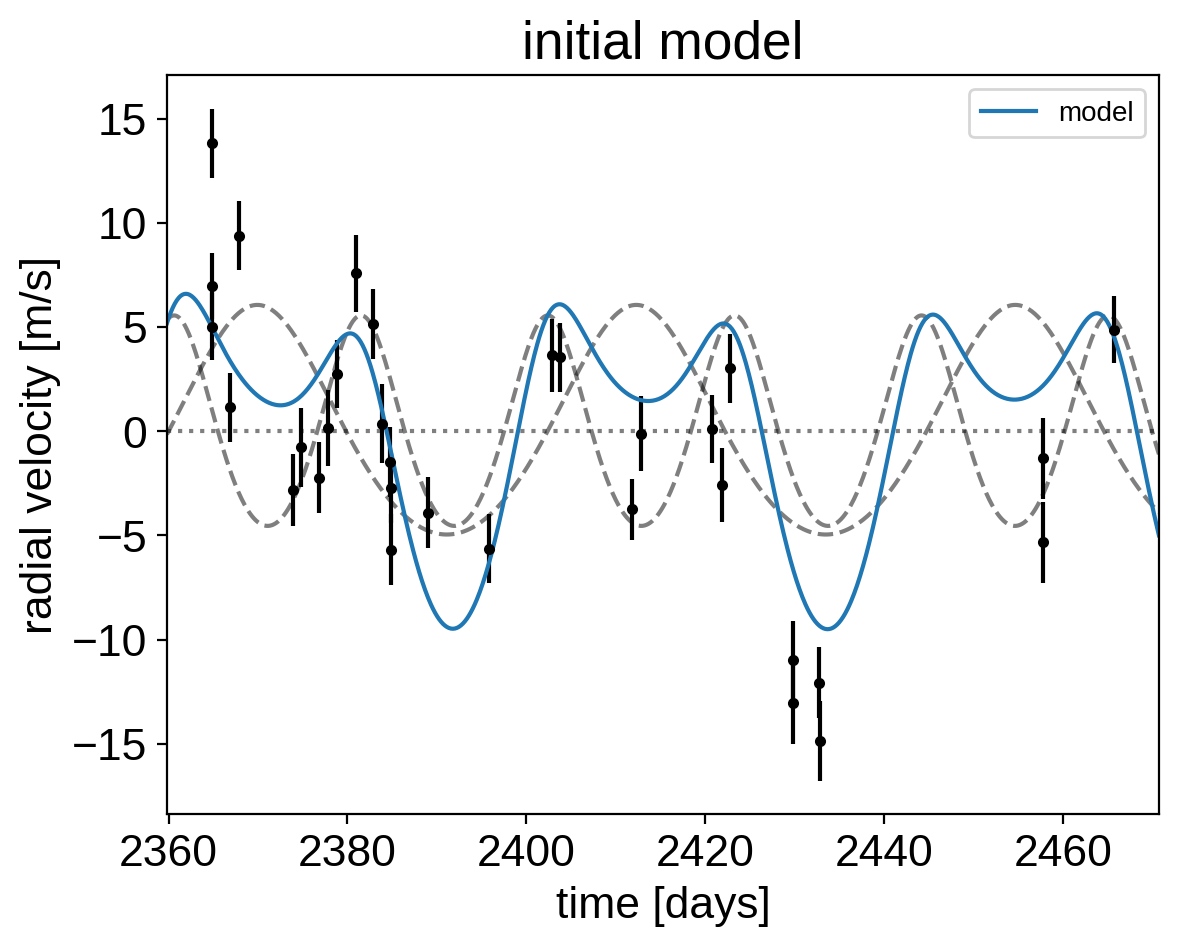

In [8]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

with model:
    plt.plot(t, xo.eval_in_model(vrad_pred), "--k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(bkg_pred), ":k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(rv_model_pred), label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("initial model");

In this plot, the background is the dotted line, the individual planets are the dashed lines, and the full model is the blue line.

It doesn't look amazing so let's add in the likelihood and fit for the maximum a posterior parameters.

In [9]:
with model:
    
    err = tt.sqrt(yerr**2 + tt.exp(2*logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y)
    
    map_soln = xo.optimize(start=model.test_point, vars=[trend])
    map_soln = xo.optimize(start=map_soln)

optimizing logp for variables: ['trend']


message: Optimization terminated successfully.
logp: -85.64878196427782 -> -70.76432173140468


optimizing logp for variables: ['trend', 'logs', 'omega_angle__', 'ecc_logodds__', 'logK', 'P', 't0']


message: Desired error not necessarily achieved due to precision loss.
logp: -70.76432173140468 -> -21.51500432166408


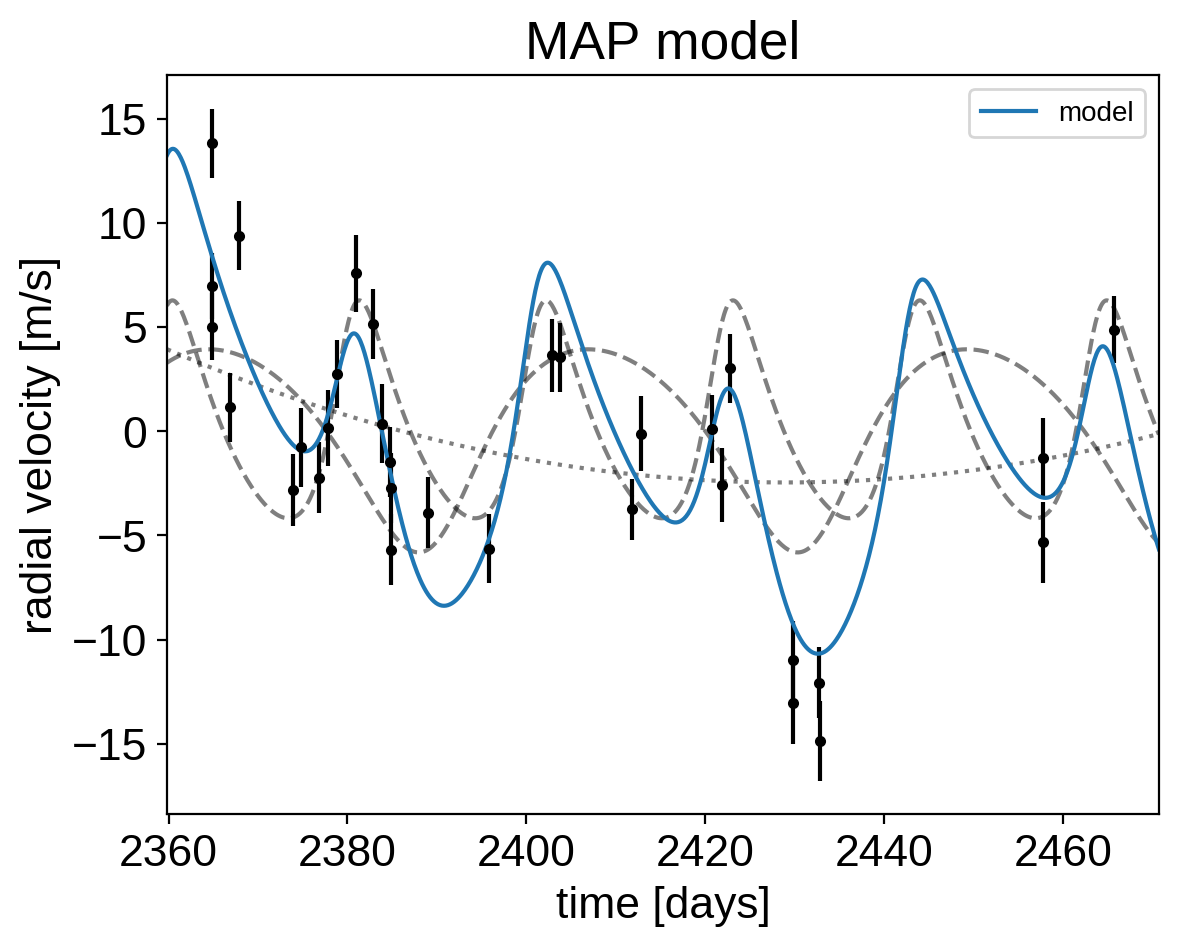

In [10]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.plot(t, map_soln["vrad_pred"], "--k", alpha=0.5)
plt.plot(t, map_soln["bkg_pred"], ":k", alpha=0.5)
plt.plot(t, map_soln["rv_model_pred"], label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("MAP model");

That looks better.

## Sampling

Now that we have our model set up and a good estimate of the initial parameters, let's start sampling.
There are substantial covariances between some of the parameters so we'll use a :class:`exoplanet.PyMC3Sampler` to tune the sampler (see the :ref:`pymc3-extras` tutorial for more information).

In [11]:
np.random.seed(42)
sampler = xo.PyMC3Sampler(start=200, window=100, finish=300)
with model:
    burnin = sampler.tune(tune=4000, start=model.test_point,
                          step_kwargs=dict(target_accept=0.95))
    trace = sampler.sample(draws=4000)

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:00<00:05, 153.32draws/s]

Sampling 4 chains:   4%|▎         | 29/808 [00:00<00:06, 116.77draws/s]

Sampling 4 chains:   5%|▍         | 38/808 [00:00<00:07, 106.25draws/s]

Sampling 4 chains:   6%|▌         | 47/808 [00:00<00:07, 95.36draws/s] 

Sampling 4 chains:   7%|▋         | 55/808 [00:00<00:08, 90.12draws/s]

Sampling 4 chains:   8%|▊         | 64/808 [00:00<00:08, 86.09draws/s]

Sampling 4 chains:   9%|▉         | 72/808 [00:00<00:08, 82.78draws/s]

Sampling 4 chains:  10%|▉         | 80/808 [00:00<00:08, 80.92draws/s]

Sampling 4 chains:  11%|█         | 89/808 [00:00<00:08, 83.05draws/s]

Sampling 4 chains:  12%|█▏        | 97/808 [00:01<00:08, 80.88draws/s]

Sampling 4 chains:  13%|█▎        | 106/808 [00:01<00:08, 78.91draws/s]

Sampling 4 chains:  14%|█▍        | 114/808 [00:01<00:08, 77.92draws/s]

Sampling 4 chains:  15%|█▌        | 122/808 [00:01<00:08, 77.79draws/s]

Sampling 4 chains:  16%|█▌        | 131/808 [00:01<00:08, 79.53draws/s]

Sampling 4 chains:  17%|█▋        | 139/808 [00:01<00:08, 78.76draws/s]

Sampling 4 chains:  18%|█▊        | 148/808 [00:01<00:08, 81.01draws/s]

Sampling 4 chains:  19%|█▉        | 157/808 [00:01<00:07, 81.76draws/s]

Sampling 4 chains:  21%|██        | 166/808 [00:01<00:08, 78.23draws/s]

Sampling 4 chains:  22%|██▏       | 175/808 [00:02<00:07, 80.26draws/s]

Sampling 4 chains:  23%|██▎       | 184/808 [00:02<00:07, 81.01draws/s]

Sampling 4 chains:  24%|██▍       | 193/808 [00:02<00:08, 75.99draws/s]

Sampling 4 chains:  25%|██▍       | 201/808 [00:02<00:07, 76.98draws/s]

Sampling 4 chains:  26%|██▌       | 210/808 [00:02<00:07, 80.17draws/s]

Sampling 4 chains:  27%|██▋       | 219/808 [00:02<00:07, 80.89draws/s]

Sampling 4 chains:  28%|██▊       | 228/808 [00:02<00:07, 81.36draws/s]

Sampling 4 chains:  29%|██▉       | 237/808 [00:02<00:06, 82.66draws/s]

Sampling 4 chains:  30%|███       | 246/808 [00:02<00:06, 81.13draws/s]

Sampling 4 chains:  32%|███▏      | 255/808 [00:03<00:06, 81.31draws/s]

Sampling 4 chains:  33%|███▎      | 264/808 [00:03<00:06, 80.57draws/s]

Sampling 4 chains:  34%|███▍      | 273/808 [00:03<00:06, 76.74draws/s]

Sampling 4 chains:  35%|███▍      | 282/808 [00:03<00:06, 76.85draws/s]

Sampling 4 chains:  36%|███▌      | 291/808 [00:03<00:06, 79.94draws/s]

Sampling 4 chains:  37%|███▋      | 300/808 [00:03<00:06, 80.36draws/s]

Sampling 4 chains:  38%|███▊      | 309/808 [00:03<00:06, 79.50draws/s]

Sampling 4 chains:  39%|███▉      | 317/808 [00:03<00:06, 79.59draws/s]

Sampling 4 chains:  40%|████      | 325/808 [00:03<00:06, 78.89draws/s]

Sampling 4 chains:  41%|████      | 333/808 [00:04<00:06, 77.94draws/s]

Sampling 4 chains:  42%|████▏     | 341/808 [00:04<00:06, 76.39draws/s]

Sampling 4 chains:  43%|████▎     | 349/808 [00:04<00:06, 76.24draws/s]

Sampling 4 chains:  44%|████▍     | 357/808 [00:04<00:05, 76.65draws/s]

Sampling 4 chains:  45%|████▌     | 365/808 [00:04<00:05, 77.53draws/s]

Sampling 4 chains:  46%|████▌     | 373/808 [00:04<00:05, 78.19draws/s]

Sampling 4 chains:  47%|████▋     | 381/808 [00:04<00:05, 78.67draws/s]

Sampling 4 chains:  48%|████▊     | 389/808 [00:04<00:05, 79.06draws/s]

Sampling 4 chains:  49%|████▉     | 398/808 [00:04<00:05, 81.56draws/s]

Sampling 4 chains:  50%|█████     | 407/808 [00:04<00:04, 83.58draws/s]

Sampling 4 chains:  51%|█████▏    | 416/808 [00:05<00:05, 77.50draws/s]

Sampling 4 chains:  52%|█████▏    | 424/808 [00:05<00:04, 77.20draws/s]

Sampling 4 chains:  54%|█████▎    | 433/808 [00:05<00:04, 79.91draws/s]

Sampling 4 chains:  55%|█████▍    | 442/808 [00:05<00:04, 81.92draws/s]

Sampling 4 chains:  56%|█████▌    | 451/808 [00:05<00:04, 82.01draws/s]

Sampling 4 chains:  57%|█████▋    | 460/808 [00:05<00:04, 77.47draws/s]

Sampling 4 chains:  58%|█████▊    | 469/808 [00:05<00:04, 79.53draws/s]

Sampling 4 chains:  59%|█████▉    | 478/808 [00:05<00:04, 77.96draws/s]

Sampling 4 chains:  60%|██████    | 486/808 [00:06<00:04, 78.50draws/s]

Sampling 4 chains:  61%|██████    | 494/808 [00:06<00:03, 78.90draws/s]

Sampling 4 chains:  62%|██████▏   | 502/808 [00:06<00:03, 79.19draws/s]

Sampling 4 chains:  63%|██████▎   | 510/808 [00:06<00:03, 79.35draws/s]

Sampling 4 chains:  64%|██████▍   | 518/808 [00:06<00:03, 79.51draws/s]

Sampling 4 chains:  65%|██████▌   | 526/808 [00:06<00:03, 79.18draws/s]

Sampling 4 chains:  66%|██████▌   | 534/808 [00:06<00:03, 78.67draws/s]

Sampling 4 chains:  67%|██████▋   | 542/808 [00:06<00:03, 78.36draws/s]

Sampling 4 chains:  68%|██████▊   | 551/808 [00:06<00:03, 79.77draws/s]

Sampling 4 chains:  69%|██████▉   | 559/808 [00:06<00:03, 79.04draws/s]

Sampling 4 chains:  70%|███████   | 569/808 [00:07<00:03, 78.53draws/s]

Sampling 4 chains:  71%|███████▏  | 577/808 [00:07<00:02, 78.96draws/s]

Sampling 4 chains:  73%|███████▎  | 586/808 [00:07<00:02, 81.36draws/s]

Sampling 4 chains:  74%|███████▎  | 595/808 [00:07<00:02, 80.74draws/s]

Sampling 4 chains:  75%|███████▍  | 604/808 [00:07<00:02, 82.03draws/s]

Sampling 4 chains:  76%|███████▌  | 613/808 [00:07<00:02, 79.89draws/s]

Sampling 4 chains:  77%|███████▋  | 622/808 [00:07<00:02, 79.42draws/s]

Sampling 4 chains:  78%|███████▊  | 631/808 [00:07<00:02, 77.65draws/s]

Sampling 4 chains:  79%|███████▉  | 640/808 [00:07<00:02, 78.59draws/s]

Sampling 4 chains:  80%|████████  | 649/808 [00:08<00:02, 78.22draws/s]

Sampling 4 chains:  81%|████████▏ | 658/808 [00:08<00:01, 79.54draws/s]

Sampling 4 chains:  82%|████████▏ | 666/808 [00:08<00:01, 78.44draws/s]

Sampling 4 chains:  83%|████████▎ | 674/808 [00:08<00:01, 77.75draws/s]

Sampling 4 chains:  84%|████████▍ | 682/808 [00:08<00:01, 78.25draws/s]

Sampling 4 chains:  86%|████████▌ | 691/808 [00:08<00:01, 81.02draws/s]

Sampling 4 chains:  87%|████████▋ | 700/808 [00:08<00:01, 80.77draws/s]

Sampling 4 chains:  88%|████████▊ | 709/808 [00:08<00:01, 80.49draws/s]

Sampling 4 chains:  89%|████████▉ | 718/808 [00:08<00:01, 79.70draws/s]

Sampling 4 chains:  90%|████████▉ | 727/808 [00:09<00:00, 81.19draws/s]

Sampling 4 chains:  91%|█████████ | 736/808 [00:09<00:00, 77.69draws/s]

Sampling 4 chains:  92%|█████████▏| 745/808 [00:09<00:00, 79.12draws/s]

Sampling 4 chains:  93%|█████████▎| 753/808 [00:09<00:00, 78.23draws/s]

Sampling 4 chains:  94%|█████████▍| 762/808 [00:09<00:00, 79.31draws/s]

Sampling 4 chains:  95%|█████████▌| 771/808 [00:09<00:00, 79.80draws/s]

Sampling 4 chains:  96%|█████████▋| 779/808 [00:09<00:00, 78.67draws/s]

Sampling 4 chains:  97%|█████████▋| 787/808 [00:09<00:00, 73.83draws/s]

Sampling 4 chains:  98%|█████████▊| 795/808 [00:10<00:00, 60.05draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [00:10<00:00, 48.39draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:10<00:00, 23.26draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   5%|▌         | 21/408 [00:00<00:02, 162.37draws/s]

Sampling 4 chains:   7%|▋         | 29/408 [00:00<00:03, 123.75draws/s]

Sampling 4 chains:   9%|▉         | 37/408 [00:00<00:03, 106.08draws/s]

Sampling 4 chains:  11%|█         | 45/408 [00:00<00:03, 96.45draws/s] 

Sampling 4 chains:  13%|█▎        | 55/408 [00:00<00:03, 97.41draws/s]

Sampling 4 chains:  15%|█▌        | 63/408 [00:00<00:03, 91.34draws/s]

Sampling 4 chains:  17%|█▋        | 71/408 [00:00<00:03, 86.99draws/s]

Sampling 4 chains:  20%|█▉        | 81/408 [00:00<00:03, 90.39draws/s]

Sampling 4 chains:  23%|██▎       | 92/408 [00:00<00:03, 88.74draws/s]

Sampling 4 chains:  25%|██▍       | 101/408 [00:01<00:03, 88.83draws/s]

Sampling 4 chains:  27%|██▋       | 110/408 [00:01<00:03, 88.42draws/s]

Sampling 4 chains:  29%|██▉       | 119/408 [00:01<00:03, 88.11draws/s]

Sampling 4 chains:  31%|███▏      | 128/408 [00:01<00:03, 88.22draws/s]

Sampling 4 chains:  34%|███▍      | 138/408 [00:01<00:02, 91.10draws/s]

Sampling 4 chains:  36%|███▋      | 148/408 [00:01<00:02, 92.34draws/s]

Sampling 4 chains:  39%|███▊      | 158/408 [00:01<00:02, 85.88draws/s]

Sampling 4 chains:  41%|████      | 167/408 [00:01<00:02, 85.63draws/s]

Sampling 4 chains:  43%|████▎     | 176/408 [00:01<00:02, 86.40draws/s]

Sampling 4 chains:  45%|████▌     | 185/408 [00:02<00:02, 86.87draws/s]

Sampling 4 chains:  48%|████▊     | 194/408 [00:02<00:02, 85.15draws/s]

Sampling 4 chains:  50%|████▉     | 203/408 [00:02<00:02, 85.73draws/s]

Sampling 4 chains:  52%|█████▏    | 212/408 [00:02<00:02, 86.91draws/s]

Sampling 4 chains:  54%|█████▍    | 221/408 [00:02<00:02, 79.74draws/s]

Sampling 4 chains:  56%|█████▋    | 230/408 [00:02<00:02, 81.02draws/s]

Sampling 4 chains:  59%|█████▊    | 239/408 [00:02<00:02, 82.89draws/s]

Sampling 4 chains:  61%|██████    | 248/408 [00:02<00:01, 82.64draws/s]

Sampling 4 chains:  63%|██████▎   | 257/408 [00:02<00:01, 83.92draws/s]

Sampling 4 chains:  65%|██████▌   | 266/408 [00:02<00:01, 85.11draws/s]

Sampling 4 chains:  67%|██████▋   | 275/408 [00:03<00:01, 81.99draws/s]

Sampling 4 chains:  70%|██████▉   | 284/408 [00:03<00:01, 81.29draws/s]

Sampling 4 chains:  72%|███████▏  | 293/408 [00:03<00:01, 82.78draws/s]

Sampling 4 chains:  75%|███████▍  | 304/408 [00:03<00:01, 85.48draws/s]

Sampling 4 chains:  77%|███████▋  | 313/408 [00:03<00:01, 86.68draws/s]

Sampling 4 chains:  79%|███████▉  | 322/408 [00:03<00:00, 86.71draws/s]

Sampling 4 chains:  81%|████████  | 331/408 [00:03<00:00, 85.89draws/s]

Sampling 4 chains:  83%|████████▎ | 340/408 [00:03<00:00, 83.11draws/s]

Sampling 4 chains:  86%|████████▌ | 349/408 [00:03<00:00, 84.89draws/s]

Sampling 4 chains:  88%|████████▊ | 359/408 [00:04<00:00, 86.03draws/s]

Sampling 4 chains:  90%|█████████ | 369/408 [00:04<00:00, 89.56draws/s]

Sampling 4 chains:  93%|█████████▎| 379/408 [00:04<00:00, 88.76draws/s]

Sampling 4 chains:  95%|█████████▌| 389/408 [00:04<00:00, 89.61draws/s]

Sampling 4 chains:  98%|█████████▊| 398/408 [00:04<00:00, 86.90draws/s]

Sampling 4 chains: 100%|█████████▉| 407/408 [00:04<00:00, 56.28draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:04<00:00, 84.23draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 18/808 [00:00<00:05, 157.58draws/s]

Sampling 4 chains:   4%|▍         | 32/808 [00:00<00:05, 147.43draws/s]

Sampling 4 chains:   6%|▌         | 45/808 [00:00<00:05, 140.19draws/s]

Sampling 4 chains:   8%|▊         | 65/808 [00:00<00:04, 151.97draws/s]

Sampling 4 chains:  11%|█         | 87/808 [00:00<00:04, 163.39draws/s]

Sampling 4 chains:  13%|█▎        | 106/808 [00:00<00:04, 166.19draws/s]

Sampling 4 chains:  16%|█▌        | 131/808 [00:00<00:03, 183.97draws/s]

Sampling 4 chains:  19%|█▉        | 156/808 [00:00<00:03, 199.24draws/s]

Sampling 4 chains:  22%|██▏       | 181/808 [00:00<00:02, 210.86draws/s]

Sampling 4 chains:  25%|██▌       | 204/808 [00:01<00:02, 212.31draws/s]

Sampling 4 chains:  28%|██▊       | 227/808 [00:01<00:02, 216.21draws/s]

Sampling 4 chains:  31%|███▏      | 254/808 [00:01<00:02, 227.50draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [00:01<00:02, 210.03draws/s]

Sampling 4 chains:  37%|███▋      | 301/808 [00:01<00:02, 217.01draws/s]

Sampling 4 chains:  41%|████      | 328/808 [00:01<00:02, 229.94draws/s]

Sampling 4 chains:  44%|████▍     | 356/808 [00:01<00:01, 237.92draws/s]

Sampling 4 chains:  48%|████▊     | 385/808 [00:01<00:01, 250.13draws/s]

Sampling 4 chains:  51%|█████▏    | 416/808 [00:01<00:01, 264.70draws/s]

Sampling 4 chains:  55%|█████▍    | 444/808 [00:02<00:01, 237.53draws/s]

Sampling 4 chains:  58%|█████▊    | 469/808 [00:02<00:01, 225.52draws/s]

Sampling 4 chains:  61%|██████    | 493/808 [00:02<00:01, 217.63draws/s]

Sampling 4 chains:  64%|██████▍   | 516/808 [00:02<00:01, 210.33draws/s]

Sampling 4 chains:  67%|██████▋   | 540/808 [00:02<00:01, 218.21draws/s]

Sampling 4 chains:  70%|███████   | 568/808 [00:02<00:01, 233.33draws/s]

Sampling 4 chains:  74%|███████▍  | 596/808 [00:02<00:00, 242.84draws/s]

Sampling 4 chains:  77%|███████▋  | 621/808 [00:02<00:00, 244.46draws/s]

Sampling 4 chains:  80%|███████▉  | 646/808 [00:02<00:00, 235.71draws/s]

Sampling 4 chains:  83%|████████▎ | 672/808 [00:03<00:00, 228.58draws/s]

Sampling 4 chains:  87%|████████▋ | 703/808 [00:03<00:00, 246.66draws/s]

Sampling 4 chains:  91%|█████████ | 733/808 [00:03<00:00, 259.10draws/s]

Sampling 4 chains:  95%|█████████▍| 766/808 [00:03<00:00, 274.19draws/s]

Sampling 4 chains:  98%|█████████▊| 795/808 [00:03<00:00, 216.98draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:03<00:00, 216.83draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 44/1608 [00:00<00:03, 437.98draws/s]

Sampling 4 chains:   5%|▌         | 84/1608 [00:00<00:03, 421.58draws/s]

Sampling 4 chains:   7%|▋         | 113/1608 [00:00<00:04, 370.53draws/s]

Sampling 4 chains:   9%|▉         | 152/1608 [00:00<00:03, 374.13draws/s]

Sampling 4 chains:  12%|█▏        | 197/1608 [00:00<00:03, 393.32draws/s]

Sampling 4 chains:  15%|█▌        | 242/1608 [00:00<00:03, 406.39draws/s]

Sampling 4 chains:  19%|█▊        | 300/1608 [00:00<00:02, 446.33draws/s]

Sampling 4 chains:  22%|██▏       | 359/1608 [00:00<00:02, 479.33draws/s]

Sampling 4 chains:  26%|██▌       | 416/1608 [00:00<00:02, 502.62draws/s]

Sampling 4 chains:  29%|██▉       | 469/1608 [00:01<00:02, 505.55draws/s]

Sampling 4 chains:  33%|███▎      | 528/1608 [00:01<00:02, 526.78draws/s]

Sampling 4 chains:  36%|███▌      | 582/1608 [00:01<00:01, 529.75draws/s]

Sampling 4 chains:  40%|███▉      | 636/1608 [00:01<00:01, 530.40draws/s]

Sampling 4 chains:  43%|████▎     | 695/1608 [00:01<00:01, 545.28draws/s]

Sampling 4 chains:  47%|████▋     | 750/1608 [00:01<00:01, 542.66draws/s]

Sampling 4 chains:  50%|█████     | 805/1608 [00:01<00:01, 542.24draws/s]

Sampling 4 chains:  54%|█████▎    | 861/1608 [00:01<00:01, 543.35draws/s]

Sampling 4 chains:  57%|█████▋    | 916/1608 [00:01<00:01, 543.14draws/s]

Sampling 4 chains:  60%|██████    | 971/1608 [00:01<00:01, 522.30draws/s]

Sampling 4 chains:  64%|██████▎   | 1024/1608 [00:02<00:01, 521.08draws/s]

Sampling 4 chains:  67%|██████▋   | 1077/1608 [00:02<00:01, 479.11draws/s]

Sampling 4 chains:  70%|███████   | 1126/1608 [00:02<00:01, 455.78draws/s]

Sampling 4 chains:  73%|███████▎  | 1177/1608 [00:02<00:00, 469.03draws/s]

Sampling 4 chains:  76%|███████▌  | 1226/1608 [00:02<00:00, 474.04draws/s]

Sampling 4 chains:  79%|███████▉  | 1276/1608 [00:02<00:00, 478.71draws/s]

Sampling 4 chains:  82%|████████▏ | 1325/1608 [00:02<00:00, 458.03draws/s]

Sampling 4 chains:  85%|████████▌ | 1372/1608 [00:02<00:00, 415.96draws/s]

Sampling 4 chains:  88%|████████▊ | 1415/1608 [00:02<00:00, 414.11draws/s]

Sampling 4 chains:  91%|█████████ | 1458/1608 [00:03<00:00, 361.84draws/s]

Sampling 4 chains:  93%|█████████▎| 1496/1608 [00:03<00:00, 296.68draws/s]

Sampling 4 chains:  95%|█████████▌| 1529/1608 [00:03<00:00, 197.50draws/s]

Sampling 4 chains:  97%|█████████▋| 1556/1608 [00:04<00:00, 106.91draws/s]

Sampling 4 chains:  98%|█████████▊| 1576/1608 [00:04<00:00, 100.92draws/s]

Sampling 4 chains:  99%|█████████▉| 1593/1608 [00:04<00:00, 93.91draws/s] 

Sampling 4 chains: 100%|██████████| 1608/1608 [00:04<00:00, 99.73draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 40/3208 [00:00<00:07, 396.12draws/s]

Sampling 4 chains:   3%|▎         | 86/3208 [00:00<00:07, 412.92draws/s]

Sampling 4 chains:   4%|▍         | 143/3208 [00:00<00:06, 447.75draws/s]

Sampling 4 chains:   6%|▌         | 189/3208 [00:00<00:06, 450.50draws/s]

Sampling 4 chains:   7%|▋         | 229/3208 [00:00<00:06, 428.85draws/s]

Sampling 4 chains:   8%|▊         | 266/3208 [00:00<00:07, 368.22draws/s]

Sampling 4 chains:  10%|▉         | 311/3208 [00:00<00:07, 387.44draws/s]

Sampling 4 chains:  11%|█▏        | 365/3208 [00:00<00:06, 422.99draws/s]

Sampling 4 chains:  13%|█▎        | 426/3208 [00:00<00:05, 464.66draws/s]

Sampling 4 chains:  15%|█▍        | 477/3208 [00:01<00:05, 476.98draws/s]

Sampling 4 chains:  16%|█▋        | 526/3208 [00:01<00:05, 479.75draws/s]

Sampling 4 chains:  18%|█▊        | 579/3208 [00:01<00:05, 493.54draws/s]

Sampling 4 chains:  20%|█▉        | 634/3208 [00:01<00:05, 508.56draws/s]

Sampling 4 chains:  21%|██▏       | 689/3208 [00:01<00:04, 518.89draws/s]

Sampling 4 chains:  23%|██▎       | 742/3208 [00:01<00:04, 513.49draws/s]

Sampling 4 chains:  25%|██▍       | 794/3208 [00:01<00:04, 509.29draws/s]

Sampling 4 chains:  26%|██▋       | 847/3208 [00:01<00:04, 513.44draws/s]

Sampling 4 chains:  28%|██▊       | 901/3208 [00:01<00:04, 520.19draws/s]

Sampling 4 chains:  30%|██▉       | 954/3208 [00:01<00:04, 521.26draws/s]

Sampling 4 chains:  31%|███▏      | 1008/3208 [00:02<00:04, 523.92draws/s]

Sampling 4 chains:  33%|███▎      | 1061/3208 [00:02<00:04, 524.31draws/s]

Sampling 4 chains:  35%|███▍      | 1114/3208 [00:02<00:04, 520.68draws/s]

Sampling 4 chains:  37%|███▋      | 1171/3208 [00:02<00:03, 533.25draws/s]

Sampling 4 chains:  38%|███▊      | 1225/3208 [00:02<00:03, 522.54draws/s]

Sampling 4 chains:  40%|████      | 1286/3208 [00:02<00:03, 544.06draws/s]

Sampling 4 chains:  42%|████▏     | 1342/3208 [00:02<00:03, 542.98draws/s]

Sampling 4 chains:  44%|████▎     | 1402/3208 [00:02<00:03, 558.62draws/s]

Sampling 4 chains:  45%|████▌     | 1459/3208 [00:02<00:03, 523.86draws/s]

Sampling 4 chains:  47%|████▋     | 1513/3208 [00:03<00:03, 508.81draws/s]

Sampling 4 chains:  49%|████▉     | 1565/3208 [00:03<00:03, 500.08draws/s]

Sampling 4 chains:  50%|█████     | 1620/3208 [00:03<00:03, 513.85draws/s]

Sampling 4 chains:  52%|█████▏    | 1673/3208 [00:03<00:02, 517.07draws/s]

Sampling 4 chains:  54%|█████▍    | 1727/3208 [00:03<00:02, 521.85draws/s]

Sampling 4 chains:  55%|█████▌    | 1780/3208 [00:03<00:02, 496.47draws/s]

Sampling 4 chains:  57%|█████▋    | 1837/3208 [00:03<00:02, 514.57draws/s]

Sampling 4 chains:  59%|█████▉    | 1891/3208 [00:03<00:02, 518.98draws/s]

Sampling 4 chains:  61%|██████    | 1944/3208 [00:03<00:02, 505.16draws/s]

Sampling 4 chains:  62%|██████▏   | 1995/3208 [00:03<00:02, 497.12draws/s]

Sampling 4 chains:  64%|██████▎   | 2045/3208 [00:04<00:02, 472.84draws/s]

Sampling 4 chains:  65%|██████▌   | 2093/3208 [00:04<00:02, 457.94draws/s]

Sampling 4 chains:  67%|██████▋   | 2140/3208 [00:04<00:02, 456.88draws/s]

Sampling 4 chains:  68%|██████▊   | 2186/3208 [00:04<00:02, 450.72draws/s]

Sampling 4 chains:  70%|██████▉   | 2234/3208 [00:04<00:02, 458.94draws/s]

Sampling 4 chains:  71%|███████   | 2285/3208 [00:04<00:01, 471.69draws/s]

Sampling 4 chains:  73%|███████▎  | 2341/3208 [00:04<00:01, 494.09draws/s]

Sampling 4 chains:  75%|███████▍  | 2400/3208 [00:04<00:01, 515.53draws/s]

Sampling 4 chains:  76%|███████▋  | 2453/3208 [00:04<00:01, 515.85draws/s]

Sampling 4 chains:  78%|███████▊  | 2511/3208 [00:05<00:01, 533.22draws/s]

Sampling 4 chains:  80%|████████  | 2568/3208 [00:05<00:01, 541.63draws/s]

Sampling 4 chains:  82%|████████▏ | 2624/3208 [00:05<00:01, 545.26draws/s]

Sampling 4 chains:  84%|████████▎ | 2679/3208 [00:05<00:00, 535.10draws/s]

Sampling 4 chains:  85%|████████▌ | 2740/3208 [00:05<00:00, 554.67draws/s]

Sampling 4 chains:  87%|████████▋ | 2800/3208 [00:05<00:00, 566.31draws/s]

Sampling 4 chains:  89%|████████▉ | 2857/3208 [00:05<00:00, 544.66draws/s]

Sampling 4 chains:  91%|█████████ | 2912/3208 [00:05<00:00, 536.91draws/s]

Sampling 4 chains:  92%|█████████▏| 2966/3208 [00:05<00:00, 455.69draws/s]

Sampling 4 chains:  94%|█████████▍| 3014/3208 [00:06<00:00, 388.11draws/s]

Sampling 4 chains:  95%|█████████▌| 3057/3208 [00:06<00:00, 359.61draws/s]

Sampling 4 chains:  97%|█████████▋| 3096/3208 [00:06<00:00, 342.61draws/s]

Sampling 4 chains:  98%|█████████▊| 3133/3208 [00:06<00:00, 317.47draws/s]

Sampling 4 chains:  99%|█████████▊| 3167/3208 [00:06<00:00, 313.74draws/s]

Sampling 4 chains: 100%|█████████▉| 3202/3208 [00:06<00:00, 323.22draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [00:06<00:00, 475.01draws/s]

Sampling 4 chains:   0%|          | 0/9208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 37/9208 [00:00<00:26, 347.84draws/s]

Sampling 4 chains:   1%|          | 82/9208 [00:00<00:24, 372.49draws/s]

Sampling 4 chains:   2%|▏         | 140/9208 [00:00<00:21, 413.68draws/s]

Sampling 4 chains:   2%|▏         | 185/9208 [00:00<00:21, 423.35draws/s]

Sampling 4 chains:   3%|▎         | 235/9208 [00:00<00:20, 438.83draws/s]

Sampling 4 chains:   3%|▎         | 289/9208 [00:00<00:19, 463.42draws/s]

Sampling 4 chains:   4%|▎         | 342/9208 [00:00<00:18, 479.42draws/s]

Sampling 4 chains:   4%|▍         | 396/9208 [00:00<00:17, 494.11draws/s]

Sampling 4 chains:   5%|▍         | 455/9208 [00:00<00:16, 517.11draws/s]

Sampling 4 chains:   6%|▌         | 507/9208 [00:01<00:17, 508.79draws/s]

Sampling 4 chains:   6%|▌         | 558/9208 [00:01<00:17, 502.24draws/s]

Sampling 4 chains:   7%|▋         | 608/9208 [00:01<00:17, 489.67draws/s]

Sampling 4 chains:   7%|▋         | 662/9208 [00:01<00:16, 502.94draws/s]

Sampling 4 chains:   8%|▊         | 723/9208 [00:01<00:16, 526.53draws/s]

Sampling 4 chains:   8%|▊         | 776/9208 [00:01<00:16, 518.26draws/s]

Sampling 4 chains:   9%|▉         | 829/9208 [00:01<00:16, 502.54draws/s]

Sampling 4 chains:  10%|▉         | 885/9208 [00:01<00:16, 518.17draws/s]

Sampling 4 chains:  10%|█         | 938/9208 [00:01<00:15, 521.25draws/s]

Sampling 4 chains:  11%|█         | 995/9208 [00:01<00:15, 533.17draws/s]

Sampling 4 chains:  11%|█▏        | 1049/9208 [00:02<00:15, 524.59draws/s]

Sampling 4 chains:  12%|█▏        | 1102/9208 [00:02<00:16, 504.56draws/s]

Sampling 4 chains:  13%|█▎        | 1153/9208 [00:02<00:16, 479.27draws/s]

Sampling 4 chains:  13%|█▎        | 1202/9208 [00:02<00:17, 460.38draws/s]

Sampling 4 chains:  14%|█▎        | 1254/9208 [00:02<00:16, 476.51draws/s]

Sampling 4 chains:  14%|█▍        | 1313/9208 [00:02<00:15, 504.39draws/s]

Sampling 4 chains:  15%|█▍        | 1376/9208 [00:02<00:14, 536.48draws/s]

Sampling 4 chains:  16%|█▌        | 1437/9208 [00:02<00:13, 556.41draws/s]

Sampling 4 chains:  16%|█▋        | 1498/9208 [00:02<00:13, 570.22draws/s]

Sampling 4 chains:  17%|█▋        | 1556/9208 [00:03<00:13, 560.89draws/s]

Sampling 4 chains:  18%|█▊        | 1613/9208 [00:03<00:13, 549.38draws/s]

Sampling 4 chains:  18%|█▊        | 1670/9208 [00:03<00:13, 554.34draws/s]

Sampling 4 chains:  19%|█▉        | 1729/9208 [00:03<00:13, 562.47draws/s]

Sampling 4 chains:  19%|█▉        | 1786/9208 [00:03<00:13, 543.38draws/s]

Sampling 4 chains:  20%|█▉        | 1841/9208 [00:03<00:13, 534.03draws/s]

Sampling 4 chains:  21%|██        | 1895/9208 [00:03<00:14, 521.33draws/s]

Sampling 4 chains:  21%|██        | 1949/9208 [00:03<00:13, 526.10draws/s]

Sampling 4 chains:  22%|██▏       | 2009/9208 [00:03<00:13, 544.78draws/s]

Sampling 4 chains:  22%|██▏       | 2064/9208 [00:03<00:13, 542.79draws/s]

Sampling 4 chains:  23%|██▎       | 2125/9208 [00:04<00:12, 559.94draws/s]

Sampling 4 chains:  24%|██▎       | 2183/9208 [00:04<00:12, 564.33draws/s]

Sampling 4 chains:  24%|██▍       | 2240/9208 [00:04<00:12, 558.20draws/s]

Sampling 4 chains:  25%|██▍       | 2296/9208 [00:04<00:12, 558.20draws/s]

Sampling 4 chains:  26%|██▌       | 2352/9208 [00:04<00:12, 539.00draws/s]

Sampling 4 chains:  26%|██▌       | 2407/9208 [00:04<00:12, 523.31draws/s]

Sampling 4 chains:  27%|██▋       | 2460/9208 [00:04<00:13, 503.53draws/s]

Sampling 4 chains:  27%|██▋       | 2511/9208 [00:04<00:13, 497.96draws/s]

Sampling 4 chains:  28%|██▊       | 2562/9208 [00:04<00:13, 499.75draws/s]

Sampling 4 chains:  28%|██▊       | 2620/9208 [00:05<00:12, 519.92draws/s]

Sampling 4 chains:  29%|██▉       | 2675/9208 [00:05<00:12, 528.47draws/s]

Sampling 4 chains:  30%|██▉       | 2731/9208 [00:05<00:12, 537.47draws/s]

Sampling 4 chains:  30%|███       | 2785/9208 [00:05<00:12, 530.61draws/s]

Sampling 4 chains:  31%|███       | 2839/9208 [00:05<00:12, 515.20draws/s]

Sampling 4 chains:  31%|███▏      | 2894/9208 [00:05<00:12, 524.86draws/s]

Sampling 4 chains:  32%|███▏      | 2954/9208 [00:05<00:11, 544.43draws/s]

Sampling 4 chains:  33%|███▎      | 3009/9208 [00:05<00:11, 540.30draws/s]

Sampling 4 chains:  33%|███▎      | 3064/9208 [00:05<00:11, 542.47draws/s]

Sampling 4 chains:  34%|███▍      | 3122/9208 [00:05<00:11, 551.74draws/s]

Sampling 4 chains:  35%|███▍      | 3179/9208 [00:06<00:10, 555.02draws/s]

Sampling 4 chains:  35%|███▌      | 3238/9208 [00:06<00:10, 563.29draws/s]

Sampling 4 chains:  36%|███▌      | 3297/9208 [00:06<00:10, 569.35draws/s]

Sampling 4 chains:  36%|███▋      | 3355/9208 [00:06<00:10, 554.57draws/s]

Sampling 4 chains:  37%|███▋      | 3411/9208 [00:06<00:10, 541.72draws/s]

Sampling 4 chains:  38%|███▊      | 3466/9208 [00:06<00:10, 539.09draws/s]

Sampling 4 chains:  38%|███▊      | 3521/9208 [00:06<00:10, 540.86draws/s]

Sampling 4 chains:  39%|███▉      | 3577/9208 [00:06<00:10, 542.85draws/s]

Sampling 4 chains:  39%|███▉      | 3635/9208 [00:06<00:10, 550.99draws/s]

Sampling 4 chains:  40%|████      | 3691/9208 [00:06<00:10, 549.24draws/s]

Sampling 4 chains:  41%|████      | 3746/9208 [00:07<00:10, 545.79draws/s]

Sampling 4 chains:  41%|████▏     | 3803/9208 [00:07<00:09, 550.73draws/s]

Sampling 4 chains:  42%|████▏     | 3860/9208 [00:07<00:09, 555.67draws/s]

Sampling 4 chains:  43%|████▎     | 3916/9208 [00:07<00:09, 553.99draws/s]

Sampling 4 chains:  43%|████▎     | 3972/9208 [00:07<00:09, 547.43draws/s]

Sampling 4 chains:  44%|████▍     | 4030/9208 [00:07<00:09, 554.09draws/s]

Sampling 4 chains:  44%|████▍     | 4086/9208 [00:07<00:09, 551.44draws/s]

Sampling 4 chains:  45%|████▍     | 4142/9208 [00:07<00:09, 551.73draws/s]

Sampling 4 chains:  46%|████▌     | 4200/9208 [00:07<00:08, 559.39draws/s]

Sampling 4 chains:  46%|████▌     | 4258/9208 [00:08<00:08, 563.51draws/s]

Sampling 4 chains:  47%|████▋     | 4315/9208 [00:08<00:08, 553.26draws/s]

Sampling 4 chains:  48%|████▊     | 4374/9208 [00:08<00:08, 561.81draws/s]

Sampling 4 chains:  48%|████▊     | 4432/9208 [00:08<00:08, 565.65draws/s]

Sampling 4 chains:  49%|████▉     | 4496/9208 [00:08<00:08, 585.45draws/s]

Sampling 4 chains:  49%|████▉     | 4555/9208 [00:08<00:08, 578.89draws/s]

Sampling 4 chains:  50%|█████     | 4614/9208 [00:08<00:08, 573.98draws/s]

Sampling 4 chains:  51%|█████     | 4672/9208 [00:08<00:08, 545.33draws/s]

Sampling 4 chains:  51%|█████▏    | 4727/9208 [00:08<00:08, 530.72draws/s]

Sampling 4 chains:  52%|█████▏    | 4781/9208 [00:08<00:08, 528.41draws/s]

Sampling 4 chains:  53%|█████▎    | 4835/9208 [00:09<00:08, 528.61draws/s]

Sampling 4 chains:  53%|█████▎    | 4889/9208 [00:09<00:08, 523.87draws/s]

Sampling 4 chains:  54%|█████▎    | 4947/9208 [00:09<00:07, 537.11draws/s]

Sampling 4 chains:  54%|█████▍    | 5004/9208 [00:09<00:07, 545.34draws/s]

Sampling 4 chains:  55%|█████▍    | 5062/9208 [00:09<00:07, 554.65draws/s]

Sampling 4 chains:  56%|█████▌    | 5122/9208 [00:09<00:07, 565.27draws/s]

Sampling 4 chains:  56%|█████▋    | 5180/9208 [00:09<00:07, 566.42draws/s]

Sampling 4 chains:  57%|█████▋    | 5237/9208 [00:09<00:07, 562.30draws/s]

Sampling 4 chains:  58%|█████▊    | 5297/9208 [00:09<00:06, 569.83draws/s]

Sampling 4 chains:  58%|█████▊    | 5355/9208 [00:09<00:06, 562.75draws/s]

Sampling 4 chains:  59%|█████▉    | 5412/9208 [00:10<00:07, 540.28draws/s]

Sampling 4 chains:  59%|█████▉    | 5469/9208 [00:10<00:06, 546.20draws/s]

Sampling 4 chains:  60%|██████    | 5526/9208 [00:10<00:06, 552.94draws/s]

Sampling 4 chains:  61%|██████    | 5585/9208 [00:10<00:06, 560.63draws/s]

Sampling 4 chains:  61%|██████▏   | 5642/9208 [00:10<00:06, 554.50draws/s]

Sampling 4 chains:  62%|██████▏   | 5700/9208 [00:10<00:06, 559.07draws/s]

Sampling 4 chains:  63%|██████▎   | 5756/9208 [00:10<00:06, 545.35draws/s]

Sampling 4 chains:  63%|██████▎   | 5811/9208 [00:10<00:06, 545.42draws/s]

Sampling 4 chains:  64%|██████▎   | 5868/9208 [00:10<00:06, 550.92draws/s]

Sampling 4 chains:  64%|██████▍   | 5924/9208 [00:11<00:06, 546.20draws/s]

Sampling 4 chains:  65%|██████▍   | 5979/9208 [00:11<00:05, 541.05draws/s]

Sampling 4 chains:  66%|██████▌   | 6034/9208 [00:11<00:05, 534.77draws/s]

Sampling 4 chains:  66%|██████▌   | 6091/9208 [00:11<00:05, 543.20draws/s]

Sampling 4 chains:  67%|██████▋   | 6147/9208 [00:11<00:05, 546.76draws/s]

Sampling 4 chains:  67%|██████▋   | 6203/9208 [00:11<00:05, 548.67draws/s]

Sampling 4 chains:  68%|██████▊   | 6260/9208 [00:11<00:05, 554.04draws/s]

Sampling 4 chains:  69%|██████▊   | 6316/9208 [00:11<00:05, 551.17draws/s]

Sampling 4 chains:  69%|██████▉   | 6372/9208 [00:11<00:05, 537.09draws/s]

Sampling 4 chains:  70%|██████▉   | 6426/9208 [00:11<00:05, 530.58draws/s]

Sampling 4 chains:  70%|███████   | 6480/9208 [00:12<00:05, 531.63draws/s]

Sampling 4 chains:  71%|███████   | 6535/9208 [00:12<00:04, 535.03draws/s]

Sampling 4 chains:  72%|███████▏  | 6595/9208 [00:12<00:04, 552.82draws/s]

Sampling 4 chains:  72%|███████▏  | 6653/9208 [00:12<00:04, 559.56draws/s]

Sampling 4 chains:  73%|███████▎  | 6710/9208 [00:12<00:04, 549.00draws/s]

Sampling 4 chains:  73%|███████▎  | 6766/9208 [00:12<00:04, 524.41draws/s]

Sampling 4 chains:  74%|███████▍  | 6819/9208 [00:12<00:04, 506.56draws/s]

Sampling 4 chains:  75%|███████▍  | 6873/9208 [00:12<00:04, 515.48draws/s]

Sampling 4 chains:  75%|███████▌  | 6927/9208 [00:12<00:04, 521.08draws/s]

Sampling 4 chains:  76%|███████▌  | 6980/9208 [00:12<00:04, 522.04draws/s]

Sampling 4 chains:  76%|███████▋  | 7035/9208 [00:13<00:04, 526.57draws/s]

Sampling 4 chains:  77%|███████▋  | 7092/9208 [00:13<00:03, 537.71draws/s]

Sampling 4 chains:  78%|███████▊  | 7152/9208 [00:13<00:03, 554.38draws/s]

Sampling 4 chains:  78%|███████▊  | 7212/9208 [00:13<00:03, 565.84draws/s]

Sampling 4 chains:  79%|███████▉  | 7269/9208 [00:13<00:03, 553.87draws/s]

Sampling 4 chains:  80%|███████▉  | 7325/9208 [00:13<00:03, 537.84draws/s]

Sampling 4 chains:  80%|████████  | 7380/9208 [00:13<00:03, 532.87draws/s]

Sampling 4 chains:  81%|████████  | 7434/9208 [00:13<00:03, 526.06draws/s]

Sampling 4 chains:  81%|████████▏ | 7487/9208 [00:13<00:03, 510.77draws/s]

Sampling 4 chains:  82%|████████▏ | 7539/9208 [00:14<00:03, 510.43draws/s]

Sampling 4 chains:  82%|████████▏ | 7592/9208 [00:14<00:03, 513.30draws/s]

Sampling 4 chains:  83%|████████▎ | 7644/9208 [00:14<00:03, 511.51draws/s]

Sampling 4 chains:  84%|████████▎ | 7697/9208 [00:14<00:02, 516.63draws/s]

Sampling 4 chains:  84%|████████▍ | 7751/9208 [00:14<00:02, 522.83draws/s]

Sampling 4 chains:  85%|████████▍ | 7804/9208 [00:14<00:02, 516.69draws/s]

Sampling 4 chains:  85%|████████▌ | 7858/9208 [00:14<00:02, 522.19draws/s]

Sampling 4 chains:  86%|████████▌ | 7911/9208 [00:14<00:02, 519.39draws/s]

Sampling 4 chains:  87%|████████▋ | 7965/9208 [00:14<00:02, 524.65draws/s]

Sampling 4 chains:  87%|████████▋ | 8020/9208 [00:14<00:02, 531.58draws/s]

Sampling 4 chains:  88%|████████▊ | 8074/9208 [00:15<00:02, 524.31draws/s]

Sampling 4 chains:  88%|████████▊ | 8129/9208 [00:15<00:02, 530.48draws/s]

Sampling 4 chains:  89%|████████▉ | 8185/9208 [00:15<00:01, 538.39draws/s]

Sampling 4 chains:  89%|████████▉ | 8239/9208 [00:15<00:01, 533.56draws/s]

Sampling 4 chains:  90%|█████████ | 8293/9208 [00:15<00:01, 529.16draws/s]

Sampling 4 chains:  91%|█████████ | 8350/9208 [00:15<00:01, 539.84draws/s]

Sampling 4 chains:  91%|█████████▏| 8407/9208 [00:15<00:01, 545.91draws/s]

Sampling 4 chains:  92%|█████████▏| 8467/9208 [00:15<00:01, 556.03draws/s]

Sampling 4 chains:  93%|█████████▎| 8527/9208 [00:15<00:01, 565.28draws/s]

Sampling 4 chains:  93%|█████████▎| 8584/9208 [00:16<00:01, 507.89draws/s]

Sampling 4 chains:  94%|█████████▍| 8636/9208 [00:16<00:01, 468.08draws/s]

Sampling 4 chains:  94%|█████████▍| 8685/9208 [00:16<00:01, 377.07draws/s]

Sampling 4 chains:  95%|█████████▍| 8727/9208 [00:16<00:01, 342.31draws/s]

Sampling 4 chains:  95%|█████████▌| 8765/9208 [00:16<00:01, 323.25draws/s]

Sampling 4 chains:  96%|█████████▌| 8800/9208 [00:16<00:01, 322.01draws/s]

Sampling 4 chains:  96%|█████████▌| 8834/9208 [00:16<00:01, 312.40draws/s]

Sampling 4 chains:  96%|█████████▋| 8867/9208 [00:16<00:01, 306.92draws/s]

Sampling 4 chains:  97%|█████████▋| 8899/9208 [00:17<00:01, 287.40draws/s]

Sampling 4 chains:  97%|█████████▋| 8929/9208 [00:17<00:01, 224.98draws/s]

Sampling 4 chains:  97%|█████████▋| 8955/9208 [00:17<00:01, 196.10draws/s]

Sampling 4 chains:  98%|█████████▊| 8978/9208 [00:17<00:01, 177.71draws/s]

Sampling 4 chains:  98%|█████████▊| 8998/9208 [00:17<00:01, 170.20draws/s]

Sampling 4 chains:  98%|█████████▊| 9017/9208 [00:17<00:01, 166.07draws/s]

Sampling 4 chains:  98%|█████████▊| 9035/9208 [00:18<00:01, 156.10draws/s]

Sampling 4 chains:  98%|█████████▊| 9052/9208 [00:18<00:01, 152.43draws/s]

Sampling 4 chains:  98%|█████████▊| 9068/9208 [00:18<00:00, 152.92draws/s]

Sampling 4 chains:  99%|█████████▊| 9084/9208 [00:18<00:00, 140.61draws/s]

Sampling 4 chains:  99%|█████████▉| 9099/9208 [00:18<00:00, 141.90draws/s]

Sampling 4 chains:  99%|█████████▉| 9114/9208 [00:18<00:00, 138.30draws/s]

Sampling 4 chains:  99%|█████████▉| 9129/9208 [00:18<00:00, 136.46draws/s]

Sampling 4 chains:  99%|█████████▉| 9144/9208 [00:18<00:00, 136.12draws/s]

Sampling 4 chains:  99%|█████████▉| 9158/9208 [00:18<00:00, 127.81draws/s]

Sampling 4 chains: 100%|█████████▉| 9173/9208 [00:19<00:00, 132.58draws/s]

Sampling 4 chains: 100%|█████████▉| 9187/9208 [00:19<00:00, 129.22draws/s]

Sampling 4 chains: 100%|█████████▉| 9201/9208 [00:19<00:00, 132.21draws/s]

Sampling 4 chains: 100%|██████████| 9208/9208 [00:19<00:00, 476.75draws/s]

Sampling 4 chains:   0%|          | 0/1208 [00:00<?, ?draws/s]

Sampling 4 chains:   4%|▎         | 44/1208 [00:00<00:02, 434.21draws/s]

Sampling 4 chains:   8%|▊         | 97/1208 [00:00<00:02, 458.20draws/s]

Sampling 4 chains:  13%|█▎        | 154/1208 [00:00<00:02, 485.11draws/s]

Sampling 4 chains:  16%|█▌        | 196/1208 [00:00<00:02, 462.01draws/s]

Sampling 4 chains:  20%|██        | 243/1208 [00:00<00:02, 460.90draws/s]

Sampling 4 chains:  24%|██▍       | 293/1208 [00:00<00:01, 470.71draws/s]

Sampling 4 chains:  29%|██▊       | 346/1208 [00:00<00:01, 486.84draws/s]

Sampling 4 chains:  32%|███▏      | 392/1208 [00:00<00:01, 474.92draws/s]

Sampling 4 chains:  36%|███▋      | 439/1208 [00:00<00:01, 470.54draws/s]

Sampling 4 chains:  41%|████      | 494/1208 [00:01<00:01, 491.25draws/s]

Sampling 4 chains:  46%|████▌     | 551/1208 [00:01<00:01, 510.58draws/s]

Sampling 4 chains:  50%|████▉     | 602/1208 [00:01<00:01, 488.44draws/s]

Sampling 4 chains:  54%|█████▍    | 651/1208 [00:01<00:01, 447.59draws/s]

Sampling 4 chains:  58%|█████▊    | 702/1208 [00:01<00:01, 464.31draws/s]

Sampling 4 chains:  62%|██████▏   | 750/1208 [00:01<00:00, 461.77draws/s]

Sampling 4 chains:  66%|██████▌   | 798/1208 [00:01<00:00, 467.07draws/s]

Sampling 4 chains:  70%|███████   | 847/1208 [00:01<00:00, 471.67draws/s]

Sampling 4 chains:  74%|███████▍  | 899/1208 [00:01<00:00, 484.58draws/s]

Sampling 4 chains:  78%|███████▊  | 948/1208 [00:01<00:00, 485.46draws/s]

Sampling 4 chains:  84%|████████▎ | 1009/1208 [00:02<00:00, 514.30draws/s]

Sampling 4 chains:  88%|████████▊ | 1064/1208 [00:02<00:00, 522.45draws/s]

Sampling 4 chains:  92%|█████████▏| 1117/1208 [00:02<00:00, 516.54draws/s]

Sampling 4 chains:  97%|█████████▋| 1169/1208 [00:02<00:00, 475.04draws/s]

Sampling 4 chains: 100%|██████████| 1208/1208 [00:02<00:00, 460.65draws/s]

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [trend, logs, omega, ecc, logK, P, t0]


Sampling 4 chains:   0%|          | 0/16000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 44/16000 [00:00<00:36, 432.08draws/s]

Sampling 4 chains:   1%|          | 94/16000 [00:00<00:35, 450.10draws/s]

Sampling 4 chains:   1%|          | 148/16000 [00:00<00:33, 472.18draws/s]

Sampling 4 chains:   1%|▏         | 200/16000 [00:00<00:32, 484.24draws/s]

Sampling 4 chains:   2%|▏         | 254/16000 [00:00<00:31, 498.85draws/s]

Sampling 4 chains:   2%|▏         | 313/16000 [00:00<00:30, 521.45draws/s]

Sampling 4 chains:   2%|▏         | 369/16000 [00:00<00:29, 530.03draws/s]

Sampling 4 chains:   3%|▎         | 425/16000 [00:00<00:29, 535.84draws/s]

Sampling 4 chains:   3%|▎         | 482/16000 [00:00<00:28, 543.39draws/s]

Sampling 4 chains:   3%|▎         | 535/16000 [00:01<00:29, 531.43draws/s]

Sampling 4 chains:   4%|▎         | 592/16000 [00:01<00:28, 539.57draws/s]

Sampling 4 chains:   4%|▍         | 647/16000 [00:01<00:28, 542.23draws/s]

Sampling 4 chains:   4%|▍         | 703/16000 [00:01<00:28, 545.02draws/s]

Sampling 4 chains:   5%|▍         | 758/16000 [00:01<00:28, 541.64draws/s]

Sampling 4 chains:   5%|▌         | 815/16000 [00:01<00:27, 548.63draws/s]

Sampling 4 chains:   5%|▌         | 870/16000 [00:01<00:27, 544.21draws/s]

Sampling 4 chains:   6%|▌         | 927/16000 [00:01<00:27, 550.23draws/s]

Sampling 4 chains:   6%|▌         | 984/16000 [00:01<00:27, 555.13draws/s]

Sampling 4 chains:   6%|▋         | 1040/16000 [00:01<00:27, 544.90draws/s]

Sampling 4 chains:   7%|▋         | 1096/16000 [00:02<00:27, 547.62draws/s]

Sampling 4 chains:   7%|▋         | 1152/16000 [00:02<00:26, 550.08draws/s]

Sampling 4 chains:   8%|▊         | 1208/16000 [00:02<00:27, 534.14draws/s]

Sampling 4 chains:   8%|▊         | 1262/16000 [00:02<00:27, 526.65draws/s]

Sampling 4 chains:   8%|▊         | 1315/16000 [00:02<00:28, 522.29draws/s]

Sampling 4 chains:   9%|▊         | 1368/16000 [00:02<00:28, 521.19draws/s]

Sampling 4 chains:   9%|▉         | 1424/16000 [00:02<00:27, 532.14draws/s]

Sampling 4 chains:   9%|▉         | 1481/16000 [00:02<00:26, 540.97draws/s]

Sampling 4 chains:  10%|▉         | 1538/16000 [00:02<00:26, 544.54draws/s]

Sampling 4 chains:  10%|▉         | 1596/16000 [00:02<00:26, 549.74draws/s]

Sampling 4 chains:  10%|█         | 1652/16000 [00:03<00:26, 547.13draws/s]

Sampling 4 chains:  11%|█         | 1708/16000 [00:03<00:25, 549.93draws/s]

Sampling 4 chains:  11%|█         | 1764/16000 [00:03<00:25, 551.13draws/s]

Sampling 4 chains:  11%|█▏        | 1821/16000 [00:03<00:25, 556.33draws/s]

Sampling 4 chains:  12%|█▏        | 1877/16000 [00:03<00:25, 555.10draws/s]

Sampling 4 chains:  12%|█▏        | 1933/16000 [00:03<00:25, 544.23draws/s]

Sampling 4 chains:  12%|█▏        | 1994/16000 [00:03<00:24, 561.15draws/s]

Sampling 4 chains:  13%|█▎        | 2056/16000 [00:03<00:24, 577.50draws/s]

Sampling 4 chains:  13%|█▎        | 2114/16000 [00:03<00:25, 552.24draws/s]

Sampling 4 chains:  14%|█▎        | 2170/16000 [00:04<00:25, 548.26draws/s]

Sampling 4 chains:  14%|█▍        | 2227/16000 [00:04<00:24, 553.38draws/s]

Sampling 4 chains:  14%|█▍        | 2284/16000 [00:04<00:24, 555.19draws/s]

Sampling 4 chains:  15%|█▍        | 2340/16000 [00:04<00:24, 552.98draws/s]

Sampling 4 chains:  15%|█▍        | 2396/16000 [00:04<00:25, 542.61draws/s]

Sampling 4 chains:  15%|█▌        | 2451/16000 [00:04<00:25, 537.00draws/s]

Sampling 4 chains:  16%|█▌        | 2507/16000 [00:04<00:24, 542.82draws/s]

Sampling 4 chains:  16%|█▌        | 2563/16000 [00:04<00:24, 547.76draws/s]

Sampling 4 chains:  16%|█▋        | 2623/16000 [00:04<00:23, 560.69draws/s]

Sampling 4 chains:  17%|█▋        | 2680/16000 [00:04<00:23, 557.72draws/s]

Sampling 4 chains:  17%|█▋        | 2736/16000 [00:05<00:24, 550.86draws/s]

Sampling 4 chains:  17%|█▋        | 2792/16000 [00:05<00:24, 548.03draws/s]

Sampling 4 chains:  18%|█▊        | 2848/16000 [00:05<00:23, 550.61draws/s]

Sampling 4 chains:  18%|█▊        | 2904/16000 [00:05<00:23, 547.16draws/s]

Sampling 4 chains:  18%|█▊        | 2959/16000 [00:05<00:24, 540.15draws/s]

Sampling 4 chains:  19%|█▉        | 3016/16000 [00:05<00:23, 543.82draws/s]

Sampling 4 chains:  19%|█▉        | 3071/16000 [00:05<00:24, 537.31draws/s]

Sampling 4 chains:  20%|█▉        | 3125/16000 [00:05<00:23, 536.65draws/s]

Sampling 4 chains:  20%|█▉        | 3179/16000 [00:05<00:24, 524.47draws/s]

Sampling 4 chains:  20%|██        | 3236/16000 [00:05<00:23, 535.77draws/s]

Sampling 4 chains:  21%|██        | 3292/16000 [00:06<00:23, 542.34draws/s]

Sampling 4 chains:  21%|██        | 3347/16000 [00:06<00:23, 541.74draws/s]

Sampling 4 chains:  21%|██▏       | 3403/16000 [00:06<00:23, 546.50draws/s]

Sampling 4 chains:  22%|██▏       | 3458/16000 [00:06<00:23, 544.59draws/s]

Sampling 4 chains:  22%|██▏       | 3513/16000 [00:06<00:23, 541.93draws/s]

Sampling 4 chains:  22%|██▏       | 3571/16000 [00:06<00:22, 551.54draws/s]

Sampling 4 chains:  23%|██▎       | 3627/16000 [00:06<00:22, 541.14draws/s]

Sampling 4 chains:  23%|██▎       | 3686/16000 [00:06<00:22, 553.35draws/s]

Sampling 4 chains:  23%|██▎       | 3742/16000 [00:06<00:22, 545.45draws/s]

Sampling 4 chains:  24%|██▎       | 3797/16000 [00:06<00:22, 546.19draws/s]

Sampling 4 chains:  24%|██▍       | 3853/16000 [00:07<00:22, 546.63draws/s]

Sampling 4 chains:  24%|██▍       | 3908/16000 [00:07<00:22, 543.51draws/s]

Sampling 4 chains:  25%|██▍       | 3964/16000 [00:07<00:22, 545.86draws/s]

Sampling 4 chains:  25%|██▌       | 4020/16000 [00:07<00:21, 548.57draws/s]

Sampling 4 chains:  25%|██▌       | 4075/16000 [00:07<00:21, 548.45draws/s]

Sampling 4 chains:  26%|██▌       | 4130/16000 [00:07<00:22, 537.91draws/s]

Sampling 4 chains:  26%|██▌       | 4187/16000 [00:07<00:21, 544.05draws/s]

Sampling 4 chains:  27%|██▋       | 4244/16000 [00:07<00:21, 551.32draws/s]

Sampling 4 chains:  27%|██▋       | 4300/16000 [00:07<00:21, 549.52draws/s]

Sampling 4 chains:  27%|██▋       | 4358/16000 [00:08<00:20, 557.99draws/s]

Sampling 4 chains:  28%|██▊       | 4414/16000 [00:08<00:20, 554.08draws/s]

Sampling 4 chains:  28%|██▊       | 4470/16000 [00:08<00:20, 552.13draws/s]

Sampling 4 chains:  28%|██▊       | 4526/16000 [00:08<00:21, 540.58draws/s]

Sampling 4 chains:  29%|██▊       | 4581/16000 [00:08<00:21, 536.86draws/s]

Sampling 4 chains:  29%|██▉       | 4635/16000 [00:08<00:21, 533.73draws/s]

Sampling 4 chains:  29%|██▉       | 4689/16000 [00:08<00:21, 531.36draws/s]

Sampling 4 chains:  30%|██▉       | 4745/16000 [00:08<00:20, 539.09draws/s]

Sampling 4 chains:  30%|██▉       | 4799/16000 [00:08<00:21, 528.21draws/s]

Sampling 4 chains:  30%|███       | 4852/16000 [00:08<00:21, 528.61draws/s]

Sampling 4 chains:  31%|███       | 4907/16000 [00:09<00:20, 531.92draws/s]

Sampling 4 chains:  31%|███       | 4961/16000 [00:09<00:20, 532.88draws/s]

Sampling 4 chains:  31%|███▏      | 5016/16000 [00:09<00:20, 535.68draws/s]

Sampling 4 chains:  32%|███▏      | 5073/16000 [00:09<00:20, 545.40draws/s]

Sampling 4 chains:  32%|███▏      | 5129/16000 [00:09<00:19, 549.44draws/s]

Sampling 4 chains:  32%|███▏      | 5184/16000 [00:09<00:19, 548.42draws/s]

Sampling 4 chains:  33%|███▎      | 5239/16000 [00:09<00:19, 542.72draws/s]

Sampling 4 chains:  33%|███▎      | 5297/16000 [00:09<00:19, 553.38draws/s]

Sampling 4 chains:  33%|███▎      | 5353/16000 [00:09<00:19, 545.23draws/s]

Sampling 4 chains:  34%|███▍      | 5408/16000 [00:09<00:19, 534.51draws/s]

Sampling 4 chains:  34%|███▍      | 5462/16000 [00:10<00:20, 517.88draws/s]

Sampling 4 chains:  34%|███▍      | 5517/16000 [00:10<00:19, 524.47draws/s]

Sampling 4 chains:  35%|███▍      | 5570/16000 [00:10<00:19, 523.67draws/s]

Sampling 4 chains:  35%|███▌      | 5625/16000 [00:10<00:19, 530.07draws/s]

Sampling 4 chains:  36%|███▌      | 5680/16000 [00:10<00:19, 532.21draws/s]

Sampling 4 chains:  36%|███▌      | 5737/16000 [00:10<00:18, 540.30draws/s]

Sampling 4 chains:  36%|███▌      | 5792/16000 [00:10<00:19, 524.09draws/s]

Sampling 4 chains:  37%|███▋      | 5849/16000 [00:10<00:19, 534.09draws/s]

Sampling 4 chains:  37%|███▋      | 5904/16000 [00:10<00:18, 537.04draws/s]

Sampling 4 chains:  37%|███▋      | 5965/16000 [00:10<00:18, 555.52draws/s]

Sampling 4 chains:  38%|███▊      | 6022/16000 [00:11<00:17, 557.30draws/s]

Sampling 4 chains:  38%|███▊      | 6078/16000 [00:11<00:17, 557.02draws/s]

Sampling 4 chains:  38%|███▊      | 6134/16000 [00:11<00:17, 551.88draws/s]

Sampling 4 chains:  39%|███▊      | 6190/16000 [00:11<00:18, 527.79draws/s]

Sampling 4 chains:  39%|███▉      | 6246/16000 [00:11<00:18, 534.08draws/s]

Sampling 4 chains:  39%|███▉      | 6303/16000 [00:11<00:17, 541.63draws/s]

Sampling 4 chains:  40%|███▉      | 6358/16000 [00:11<00:17, 542.11draws/s]

Sampling 4 chains:  40%|████      | 6414/16000 [00:11<00:17, 546.76draws/s]

Sampling 4 chains:  40%|████      | 6469/16000 [00:11<00:17, 540.32draws/s]

Sampling 4 chains:  41%|████      | 6529/16000 [00:12<00:17, 556.22draws/s]

Sampling 4 chains:  41%|████      | 6585/16000 [00:12<00:16, 555.84draws/s]

Sampling 4 chains:  42%|████▏     | 6641/16000 [00:12<00:16, 551.83draws/s]

Sampling 4 chains:  42%|████▏     | 6698/16000 [00:12<00:16, 556.34draws/s]

Sampling 4 chains:  42%|████▏     | 6754/16000 [00:12<00:16, 553.01draws/s]

Sampling 4 chains:  43%|████▎     | 6810/16000 [00:12<00:16, 542.85draws/s]

Sampling 4 chains:  43%|████▎     | 6869/16000 [00:12<00:16, 554.59draws/s]

Sampling 4 chains:  43%|████▎     | 6925/16000 [00:12<00:16, 546.60draws/s]

Sampling 4 chains:  44%|████▎     | 6980/16000 [00:12<00:16, 540.27draws/s]

Sampling 4 chains:  44%|████▍     | 7035/16000 [00:12<00:16, 533.70draws/s]

Sampling 4 chains:  44%|████▍     | 7092/16000 [00:13<00:16, 543.91draws/s]

Sampling 4 chains:  45%|████▍     | 7147/16000 [00:13<00:16, 541.72draws/s]

Sampling 4 chains:  45%|████▌     | 7202/16000 [00:13<00:16, 543.55draws/s]

Sampling 4 chains:  45%|████▌     | 7257/16000 [00:13<00:16, 543.49draws/s]

Sampling 4 chains:  46%|████▌     | 7313/16000 [00:13<00:15, 547.81draws/s]

Sampling 4 chains:  46%|████▌     | 7369/16000 [00:13<00:15, 548.77draws/s]

Sampling 4 chains:  46%|████▋     | 7424/16000 [00:13<00:15, 541.36draws/s]

Sampling 4 chains:  47%|████▋     | 7479/16000 [00:13<00:15, 538.71draws/s]

Sampling 4 chains:  47%|████▋     | 7533/16000 [00:13<00:16, 528.80draws/s]

Sampling 4 chains:  47%|████▋     | 7591/16000 [00:13<00:15, 540.35draws/s]

Sampling 4 chains:  48%|████▊     | 7647/16000 [00:14<00:15, 544.21draws/s]

Sampling 4 chains:  48%|████▊     | 7702/16000 [00:14<00:15, 543.08draws/s]

Sampling 4 chains:  48%|████▊     | 7760/16000 [00:14<00:14, 552.08draws/s]

Sampling 4 chains:  49%|████▉     | 7816/16000 [00:14<00:15, 537.92draws/s]

Sampling 4 chains:  49%|████▉     | 7872/16000 [00:14<00:14, 543.01draws/s]

Sampling 4 chains:  50%|████▉     | 7927/16000 [00:14<00:14, 540.55draws/s]

Sampling 4 chains:  50%|████▉     | 7985/16000 [00:14<00:14, 550.11draws/s]

Sampling 4 chains:  50%|█████     | 8041/16000 [00:14<00:14, 546.33draws/s]

Sampling 4 chains:  51%|█████     | 8096/16000 [00:14<00:14, 546.34draws/s]

Sampling 4 chains:  51%|█████     | 8151/16000 [00:15<00:14, 545.23draws/s]

Sampling 4 chains:  51%|█████▏    | 8206/16000 [00:15<00:14, 536.49draws/s]

Sampling 4 chains:  52%|█████▏    | 8260/16000 [00:15<00:14, 535.01draws/s]

Sampling 4 chains:  52%|█████▏    | 8314/16000 [00:15<00:14, 535.12draws/s]

Sampling 4 chains:  52%|█████▏    | 8368/16000 [00:15<00:14, 532.58draws/s]

Sampling 4 chains:  53%|█████▎    | 8422/16000 [00:15<00:14, 529.65draws/s]

Sampling 4 chains:  53%|█████▎    | 8478/16000 [00:15<00:14, 536.74draws/s]

Sampling 4 chains:  53%|█████▎    | 8532/16000 [00:15<00:14, 528.63draws/s]

Sampling 4 chains:  54%|█████▎    | 8585/16000 [00:15<00:14, 528.53draws/s]

Sampling 4 chains:  54%|█████▍    | 8640/16000 [00:15<00:13, 534.08draws/s]

Sampling 4 chains:  54%|█████▍    | 8695/16000 [00:16<00:13, 534.13draws/s]

Sampling 4 chains:  55%|█████▍    | 8750/16000 [00:16<00:13, 537.95draws/s]

Sampling 4 chains:  55%|█████▌    | 8806/16000 [00:16<00:13, 541.41draws/s]

Sampling 4 chains:  55%|█████▌    | 8861/16000 [00:16<00:13, 540.61draws/s]

Sampling 4 chains:  56%|█████▌    | 8916/16000 [00:16<00:13, 539.47draws/s]

Sampling 4 chains:  56%|█████▌    | 8970/16000 [00:16<00:13, 533.78draws/s]

Sampling 4 chains:  56%|█████▋    | 9027/16000 [00:16<00:12, 543.35draws/s]

Sampling 4 chains:  57%|█████▋    | 9082/16000 [00:16<00:12, 544.78draws/s]

Sampling 4 chains:  57%|█████▋    | 9137/16000 [00:16<00:12, 540.55draws/s]

Sampling 4 chains:  57%|█████▋    | 9192/16000 [00:16<00:12, 539.72draws/s]

Sampling 4 chains:  58%|█████▊    | 9246/16000 [00:17<00:12, 534.15draws/s]

Sampling 4 chains:  58%|█████▊    | 9300/16000 [00:17<00:12, 530.41draws/s]

Sampling 4 chains:  58%|█████▊    | 9354/16000 [00:17<00:12, 528.65draws/s]

Sampling 4 chains:  59%|█████▉    | 9411/16000 [00:17<00:12, 537.14draws/s]

Sampling 4 chains:  59%|█████▉    | 9466/16000 [00:17<00:12, 539.93draws/s]

Sampling 4 chains:  60%|█████▉    | 9521/16000 [00:17<00:11, 541.68draws/s]

Sampling 4 chains:  60%|█████▉    | 9576/16000 [00:17<00:11, 535.71draws/s]

Sampling 4 chains:  60%|██████    | 9634/16000 [00:17<00:11, 547.39draws/s]

Sampling 4 chains:  61%|██████    | 9689/16000 [00:17<00:11, 542.51draws/s]

Sampling 4 chains:  61%|██████    | 9746/16000 [00:17<00:11, 548.54draws/s]

Sampling 4 chains:  61%|██████▏   | 9806/16000 [00:18<00:11, 562.63draws/s]

Sampling 4 chains:  62%|██████▏   | 9863/16000 [00:18<00:11, 547.72draws/s]

Sampling 4 chains:  62%|██████▏   | 9918/16000 [00:18<00:11, 543.94draws/s]

Sampling 4 chains:  62%|██████▏   | 9974/16000 [00:18<00:11, 547.70draws/s]

Sampling 4 chains:  63%|██████▎   | 10032/16000 [00:18<00:10, 553.46draws/s]

Sampling 4 chains:  63%|██████▎   | 10088/16000 [00:18<00:10, 549.48draws/s]

Sampling 4 chains:  63%|██████▎   | 10144/16000 [00:18<00:10, 542.25draws/s]

Sampling 4 chains:  64%|██████▍   | 10200/16000 [00:18<00:10, 546.69draws/s]

Sampling 4 chains:  64%|██████▍   | 10255/16000 [00:18<00:10, 543.69draws/s]

Sampling 4 chains:  64%|██████▍   | 10310/16000 [00:19<00:10, 542.89draws/s]

Sampling 4 chains:  65%|██████▍   | 10365/16000 [00:19<00:10, 544.05draws/s]

Sampling 4 chains:  65%|██████▌   | 10422/16000 [00:19<00:10, 550.21draws/s]

Sampling 4 chains:  65%|██████▌   | 10478/16000 [00:19<00:10, 547.38draws/s]

Sampling 4 chains:  66%|██████▌   | 10533/16000 [00:19<00:09, 547.85draws/s]

Sampling 4 chains:  66%|██████▌   | 10588/16000 [00:19<00:09, 544.06draws/s]

Sampling 4 chains:  67%|██████▋   | 10647/16000 [00:19<00:09, 555.14draws/s]

Sampling 4 chains:  67%|██████▋   | 10705/16000 [00:19<00:09, 562.33draws/s]

Sampling 4 chains:  67%|██████▋   | 10762/16000 [00:19<00:09, 564.16draws/s]

Sampling 4 chains:  68%|██████▊   | 10819/16000 [00:19<00:09, 547.71draws/s]

Sampling 4 chains:  68%|██████▊   | 10874/16000 [00:20<00:09, 541.94draws/s]

Sampling 4 chains:  68%|██████▊   | 10934/16000 [00:20<00:09, 558.14draws/s]

Sampling 4 chains:  69%|██████▊   | 10991/16000 [00:20<00:09, 554.25draws/s]

Sampling 4 chains:  69%|██████▉   | 11047/16000 [00:20<00:09, 545.65draws/s]

Sampling 4 chains:  69%|██████▉   | 11102/16000 [00:20<00:09, 535.57draws/s]

Sampling 4 chains:  70%|██████▉   | 11156/16000 [00:20<00:09, 532.45draws/s]

Sampling 4 chains:  70%|███████   | 11212/16000 [00:20<00:08, 540.32draws/s]

Sampling 4 chains:  70%|███████   | 11269/16000 [00:20<00:08, 547.51draws/s]

Sampling 4 chains:  71%|███████   | 11324/16000 [00:20<00:08, 530.97draws/s]

Sampling 4 chains:  71%|███████   | 11382/16000 [00:20<00:08, 543.22draws/s]

Sampling 4 chains:  72%|███████▏  | 11442/16000 [00:21<00:08, 558.66draws/s]

Sampling 4 chains:  72%|███████▏  | 11499/16000 [00:21<00:08, 554.21draws/s]

Sampling 4 chains:  72%|███████▏  | 11555/16000 [00:21<00:08, 544.08draws/s]

Sampling 4 chains:  73%|███████▎  | 11612/16000 [00:21<00:07, 550.93draws/s]

Sampling 4 chains:  73%|███████▎  | 11670/16000 [00:21<00:07, 557.80draws/s]

Sampling 4 chains:  73%|███████▎  | 11731/16000 [00:21<00:07, 571.11draws/s]

Sampling 4 chains:  74%|███████▎  | 11789/16000 [00:21<00:07, 563.65draws/s]

Sampling 4 chains:  74%|███████▍  | 11846/16000 [00:21<00:07, 543.06draws/s]

Sampling 4 chains:  74%|███████▍  | 11903/16000 [00:21<00:07, 547.82draws/s]

Sampling 4 chains:  75%|███████▍  | 11958/16000 [00:22<00:07, 544.29draws/s]

Sampling 4 chains:  75%|███████▌  | 12014/16000 [00:22<00:07, 547.18draws/s]

Sampling 4 chains:  75%|███████▌  | 12071/16000 [00:22<00:07, 550.81draws/s]

Sampling 4 chains:  76%|███████▌  | 12127/16000 [00:22<00:07, 545.74draws/s]

Sampling 4 chains:  76%|███████▌  | 12182/16000 [00:22<00:07, 533.84draws/s]

Sampling 4 chains:  76%|███████▋  | 12239/16000 [00:22<00:06, 540.21draws/s]

Sampling 4 chains:  77%|███████▋  | 12295/16000 [00:22<00:06, 545.98draws/s]

Sampling 4 chains:  77%|███████▋  | 12352/16000 [00:22<00:06, 550.19draws/s]

Sampling 4 chains:  78%|███████▊  | 12408/16000 [00:22<00:06, 550.57draws/s]

Sampling 4 chains:  78%|███████▊  | 12464/16000 [00:22<00:06, 542.35draws/s]

Sampling 4 chains:  78%|███████▊  | 12519/16000 [00:23<00:06, 533.70draws/s]

Sampling 4 chains:  79%|███████▊  | 12579/16000 [00:23<00:06, 548.61draws/s]

Sampling 4 chains:  79%|███████▉  | 12635/16000 [00:23<00:06, 550.03draws/s]

Sampling 4 chains:  79%|███████▉  | 12691/16000 [00:23<00:05, 551.93draws/s]

Sampling 4 chains:  80%|███████▉  | 12747/16000 [00:23<00:05, 546.64draws/s]

Sampling 4 chains:  80%|████████  | 12803/16000 [00:23<00:05, 549.38draws/s]

Sampling 4 chains:  80%|████████  | 12858/16000 [00:23<00:05, 538.43draws/s]

Sampling 4 chains:  81%|████████  | 12912/16000 [00:23<00:05, 535.59draws/s]

Sampling 4 chains:  81%|████████  | 12968/16000 [00:23<00:05, 541.70draws/s]

Sampling 4 chains:  81%|████████▏ | 13025/16000 [00:23<00:05, 546.91draws/s]

Sampling 4 chains:  82%|████████▏ | 13082/16000 [00:24<00:05, 552.52draws/s]

Sampling 4 chains:  82%|████████▏ | 13138/16000 [00:24<00:05, 550.95draws/s]

Sampling 4 chains:  82%|████████▏ | 13194/16000 [00:24<00:05, 542.15draws/s]

Sampling 4 chains:  83%|████████▎ | 13252/16000 [00:24<00:04, 550.64draws/s]

Sampling 4 chains:  83%|████████▎ | 13312/16000 [00:24<00:04, 560.64draws/s]

Sampling 4 chains:  84%|████████▎ | 13370/16000 [00:24<00:04, 563.64draws/s]

Sampling 4 chains:  84%|████████▍ | 13427/16000 [00:24<00:04, 551.92draws/s]

Sampling 4 chains:  84%|████████▍ | 13483/16000 [00:24<00:04, 552.18draws/s]

Sampling 4 chains:  85%|████████▍ | 13539/16000 [00:24<00:04, 537.68draws/s]

Sampling 4 chains:  85%|████████▍ | 13596/16000 [00:24<00:04, 545.93draws/s]

Sampling 4 chains:  85%|████████▌ | 13654/16000 [00:25<00:04, 554.18draws/s]

Sampling 4 chains:  86%|████████▌ | 13710/16000 [00:25<00:04, 550.10draws/s]

Sampling 4 chains:  86%|████████▌ | 13766/16000 [00:25<00:04, 551.05draws/s]

Sampling 4 chains:  86%|████████▋ | 13823/16000 [00:25<00:03, 552.88draws/s]

Sampling 4 chains:  87%|████████▋ | 13879/16000 [00:25<00:03, 532.25draws/s]

Sampling 4 chains:  87%|████████▋ | 13933/16000 [00:25<00:03, 525.58draws/s]

Sampling 4 chains:  87%|████████▋ | 13986/16000 [00:25<00:03, 526.70draws/s]

Sampling 4 chains:  88%|████████▊ | 14044/16000 [00:25<00:03, 539.03draws/s]

Sampling 4 chains:  88%|████████▊ | 14102/16000 [00:25<00:03, 549.52draws/s]

Sampling 4 chains:  88%|████████▊ | 14158/16000 [00:26<00:03, 548.83draws/s]

Sampling 4 chains:  89%|████████▉ | 14214/16000 [00:26<00:03, 549.35draws/s]

Sampling 4 chains:  89%|████████▉ | 14272/16000 [00:26<00:03, 557.54draws/s]

Sampling 4 chains:  90%|████████▉ | 14328/16000 [00:26<00:03, 555.86draws/s]

Sampling 4 chains:  90%|████████▉ | 14384/16000 [00:26<00:02, 550.36draws/s]

Sampling 4 chains:  90%|█████████ | 14441/16000 [00:26<00:02, 555.09draws/s]

Sampling 4 chains:  91%|█████████ | 14497/16000 [00:26<00:02, 555.51draws/s]

Sampling 4 chains:  91%|█████████ | 14553/16000 [00:26<00:02, 551.16draws/s]

Sampling 4 chains:  91%|█████████▏| 14610/16000 [00:26<00:02, 555.74draws/s]

Sampling 4 chains:  92%|█████████▏| 14667/16000 [00:26<00:02, 558.71draws/s]

Sampling 4 chains:  92%|█████████▏| 14723/16000 [00:27<00:02, 551.43draws/s]

Sampling 4 chains:  92%|█████████▏| 14779/16000 [00:27<00:02, 498.40draws/s]

Sampling 4 chains:  93%|█████████▎| 14830/16000 [00:27<00:02, 473.51draws/s]

Sampling 4 chains:  93%|█████████▎| 14879/16000 [00:27<00:02, 455.93draws/s]

Sampling 4 chains:  93%|█████████▎| 14926/16000 [00:27<00:02, 440.83draws/s]

Sampling 4 chains:  94%|█████████▎| 14971/16000 [00:27<00:02, 430.53draws/s]

Sampling 4 chains:  94%|█████████▍| 15015/16000 [00:27<00:02, 421.61draws/s]

Sampling 4 chains:  94%|█████████▍| 15058/16000 [00:27<00:02, 407.45draws/s]

Sampling 4 chains:  94%|█████████▍| 15100/16000 [00:28<00:02, 374.92draws/s]

Sampling 4 chains:  95%|█████████▍| 15139/16000 [00:28<00:02, 355.50draws/s]

Sampling 4 chains:  95%|█████████▍| 15176/16000 [00:28<00:02, 339.06draws/s]

Sampling 4 chains:  95%|█████████▌| 15211/16000 [00:28<00:02, 331.03draws/s]

Sampling 4 chains:  95%|█████████▌| 15245/16000 [00:28<00:02, 319.49draws/s]

Sampling 4 chains:  95%|█████████▌| 15278/16000 [00:28<00:02, 321.11draws/s]

Sampling 4 chains:  96%|█████████▌| 15311/16000 [00:28<00:02, 321.58draws/s]

Sampling 4 chains:  96%|█████████▌| 15344/16000 [00:28<00:02, 317.49draws/s]

Sampling 4 chains:  96%|█████████▌| 15377/16000 [00:28<00:01, 319.25draws/s]

Sampling 4 chains:  96%|█████████▋| 15410/16000 [00:28<00:01, 321.21draws/s]

Sampling 4 chains:  97%|█████████▋| 15443/16000 [00:29<00:02, 249.53draws/s]

Sampling 4 chains:  97%|█████████▋| 15471/16000 [00:29<00:02, 195.98draws/s]

Sampling 4 chains:  97%|█████████▋| 15495/16000 [00:29<00:02, 180.63draws/s]

Sampling 4 chains:  97%|█████████▋| 15516/16000 [00:29<00:02, 170.78draws/s]

Sampling 4 chains:  97%|█████████▋| 15536/16000 [00:29<00:02, 162.22draws/s]

Sampling 4 chains:  97%|█████████▋| 15554/16000 [00:29<00:02, 163.92draws/s]

Sampling 4 chains:  97%|█████████▋| 15572/16000 [00:30<00:02, 158.00draws/s]

Sampling 4 chains:  97%|█████████▋| 15589/16000 [00:30<00:02, 159.86draws/s]

Sampling 4 chains:  98%|█████████▊| 15606/16000 [00:30<00:02, 159.84draws/s]

Sampling 4 chains:  98%|█████████▊| 15623/16000 [00:30<00:02, 158.37draws/s]

Sampling 4 chains:  98%|█████████▊| 15640/16000 [00:30<00:02, 152.53draws/s]

Sampling 4 chains:  98%|█████████▊| 15656/16000 [00:30<00:02, 153.55draws/s]

Sampling 4 chains:  98%|█████████▊| 15672/16000 [00:30<00:02, 152.95draws/s]

Sampling 4 chains:  98%|█████████▊| 15688/16000 [00:30<00:02, 153.84draws/s]

Sampling 4 chains:  98%|█████████▊| 15704/16000 [00:30<00:01, 152.95draws/s]

Sampling 4 chains:  98%|█████████▊| 15720/16000 [00:31<00:01, 153.94draws/s]

Sampling 4 chains:  98%|█████████▊| 15736/16000 [00:31<00:01, 154.66draws/s]

Sampling 4 chains:  98%|█████████▊| 15752/16000 [00:31<00:01, 152.23draws/s]

Sampling 4 chains:  99%|█████████▊| 15768/16000 [00:31<00:01, 153.34draws/s]

Sampling 4 chains:  99%|█████████▊| 15784/16000 [00:31<00:01, 151.21draws/s]

Sampling 4 chains:  99%|█████████▉| 15801/16000 [00:31<00:01, 155.17draws/s]

Sampling 4 chains:  99%|█████████▉| 15817/16000 [00:31<00:01, 151.26draws/s]

Sampling 4 chains:  99%|█████████▉| 15833/16000 [00:31<00:01, 149.90draws/s]

Sampling 4 chains:  99%|█████████▉| 15849/16000 [00:31<00:00, 151.70draws/s]

Sampling 4 chains:  99%|█████████▉| 15865/16000 [00:31<00:00, 153.91draws/s]

Sampling 4 chains:  99%|█████████▉| 15881/16000 [00:32<00:00, 151.86draws/s]

Sampling 4 chains:  99%|█████████▉| 15897/16000 [00:32<00:00, 151.83draws/s]

Sampling 4 chains:  99%|█████████▉| 15913/16000 [00:32<00:00, 151.83draws/s]

Sampling 4 chains: 100%|█████████▉| 15929/16000 [00:32<00:00, 150.46draws/s]

Sampling 4 chains: 100%|█████████▉| 15945/16000 [00:32<00:00, 150.76draws/s]

Sampling 4 chains: 100%|█████████▉| 15961/16000 [00:32<00:00, 148.09draws/s]

Sampling 4 chains: 100%|█████████▉| 15976/16000 [00:32<00:00, 147.70draws/s]

Sampling 4 chains: 100%|█████████▉| 15992/16000 [00:32<00:00, 148.89draws/s]

Sampling 4 chains: 100%|██████████| 16000/16000 [00:32<00:00, 486.16draws/s]

There were 15 divergences after tuning. Increase `target_accept` or reparameterize.


There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


There were 14 divergences after tuning. Increase `target_accept` or reparameterize.


There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


After sampling, it's always a good idea to do some convergence checks.
First, let's check the number of effective samples and the Gelman-Rubin statistic for our parameters of interest:

In [12]:
pm.summary(trace, varnames=["trend", "logs", "omega", "ecc", "t0", "logK", "P"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
trend__0,0.000854,0.000756,0.000006,-0.000680,0.002317,13568.105536,1.000281
trend__1,-0.039249,0.022599,0.000166,-0.085659,0.003324,16581.127183,1.000031
trend__2,-1.975109,0.801675,0.007483,-3.469826,-0.354028,14048.835088,1.000314
logs,1.041477,0.223532,0.002707,0.585050,1.453831,9213.820738,1.000190
omega__0,-0.196836,0.822498,0.010273,-1.551370,1.727274,5915.436849,1.001289
omega__1,-0.475997,2.123607,0.026657,-3.134015,2.929046,7248.251254,1.000135
ecc__0,0.196678,0.100582,0.001427,0.000006,0.364899,6451.434557,1.000413
ecc__1,0.138351,0.115085,0.001535,0.000012,0.361659,5674.936378,0.999956
t0__0,2072.794803,0.000691,0.000004,2072.793453,2072.796167,23131.001837,0.999938
t0__1,2082.625101,0.000401,0.000003,2082.624316,2082.625885,20001.907956,0.999918


It looks like everything is pretty much converged here. Not bad for 14 parameters and about a minute of runtime...

Then we can make a [corner plot](https://corner.readthedocs.io) of any combination of the parameters.
For example, let's look at period, semi-amplitude, and eccentricity:

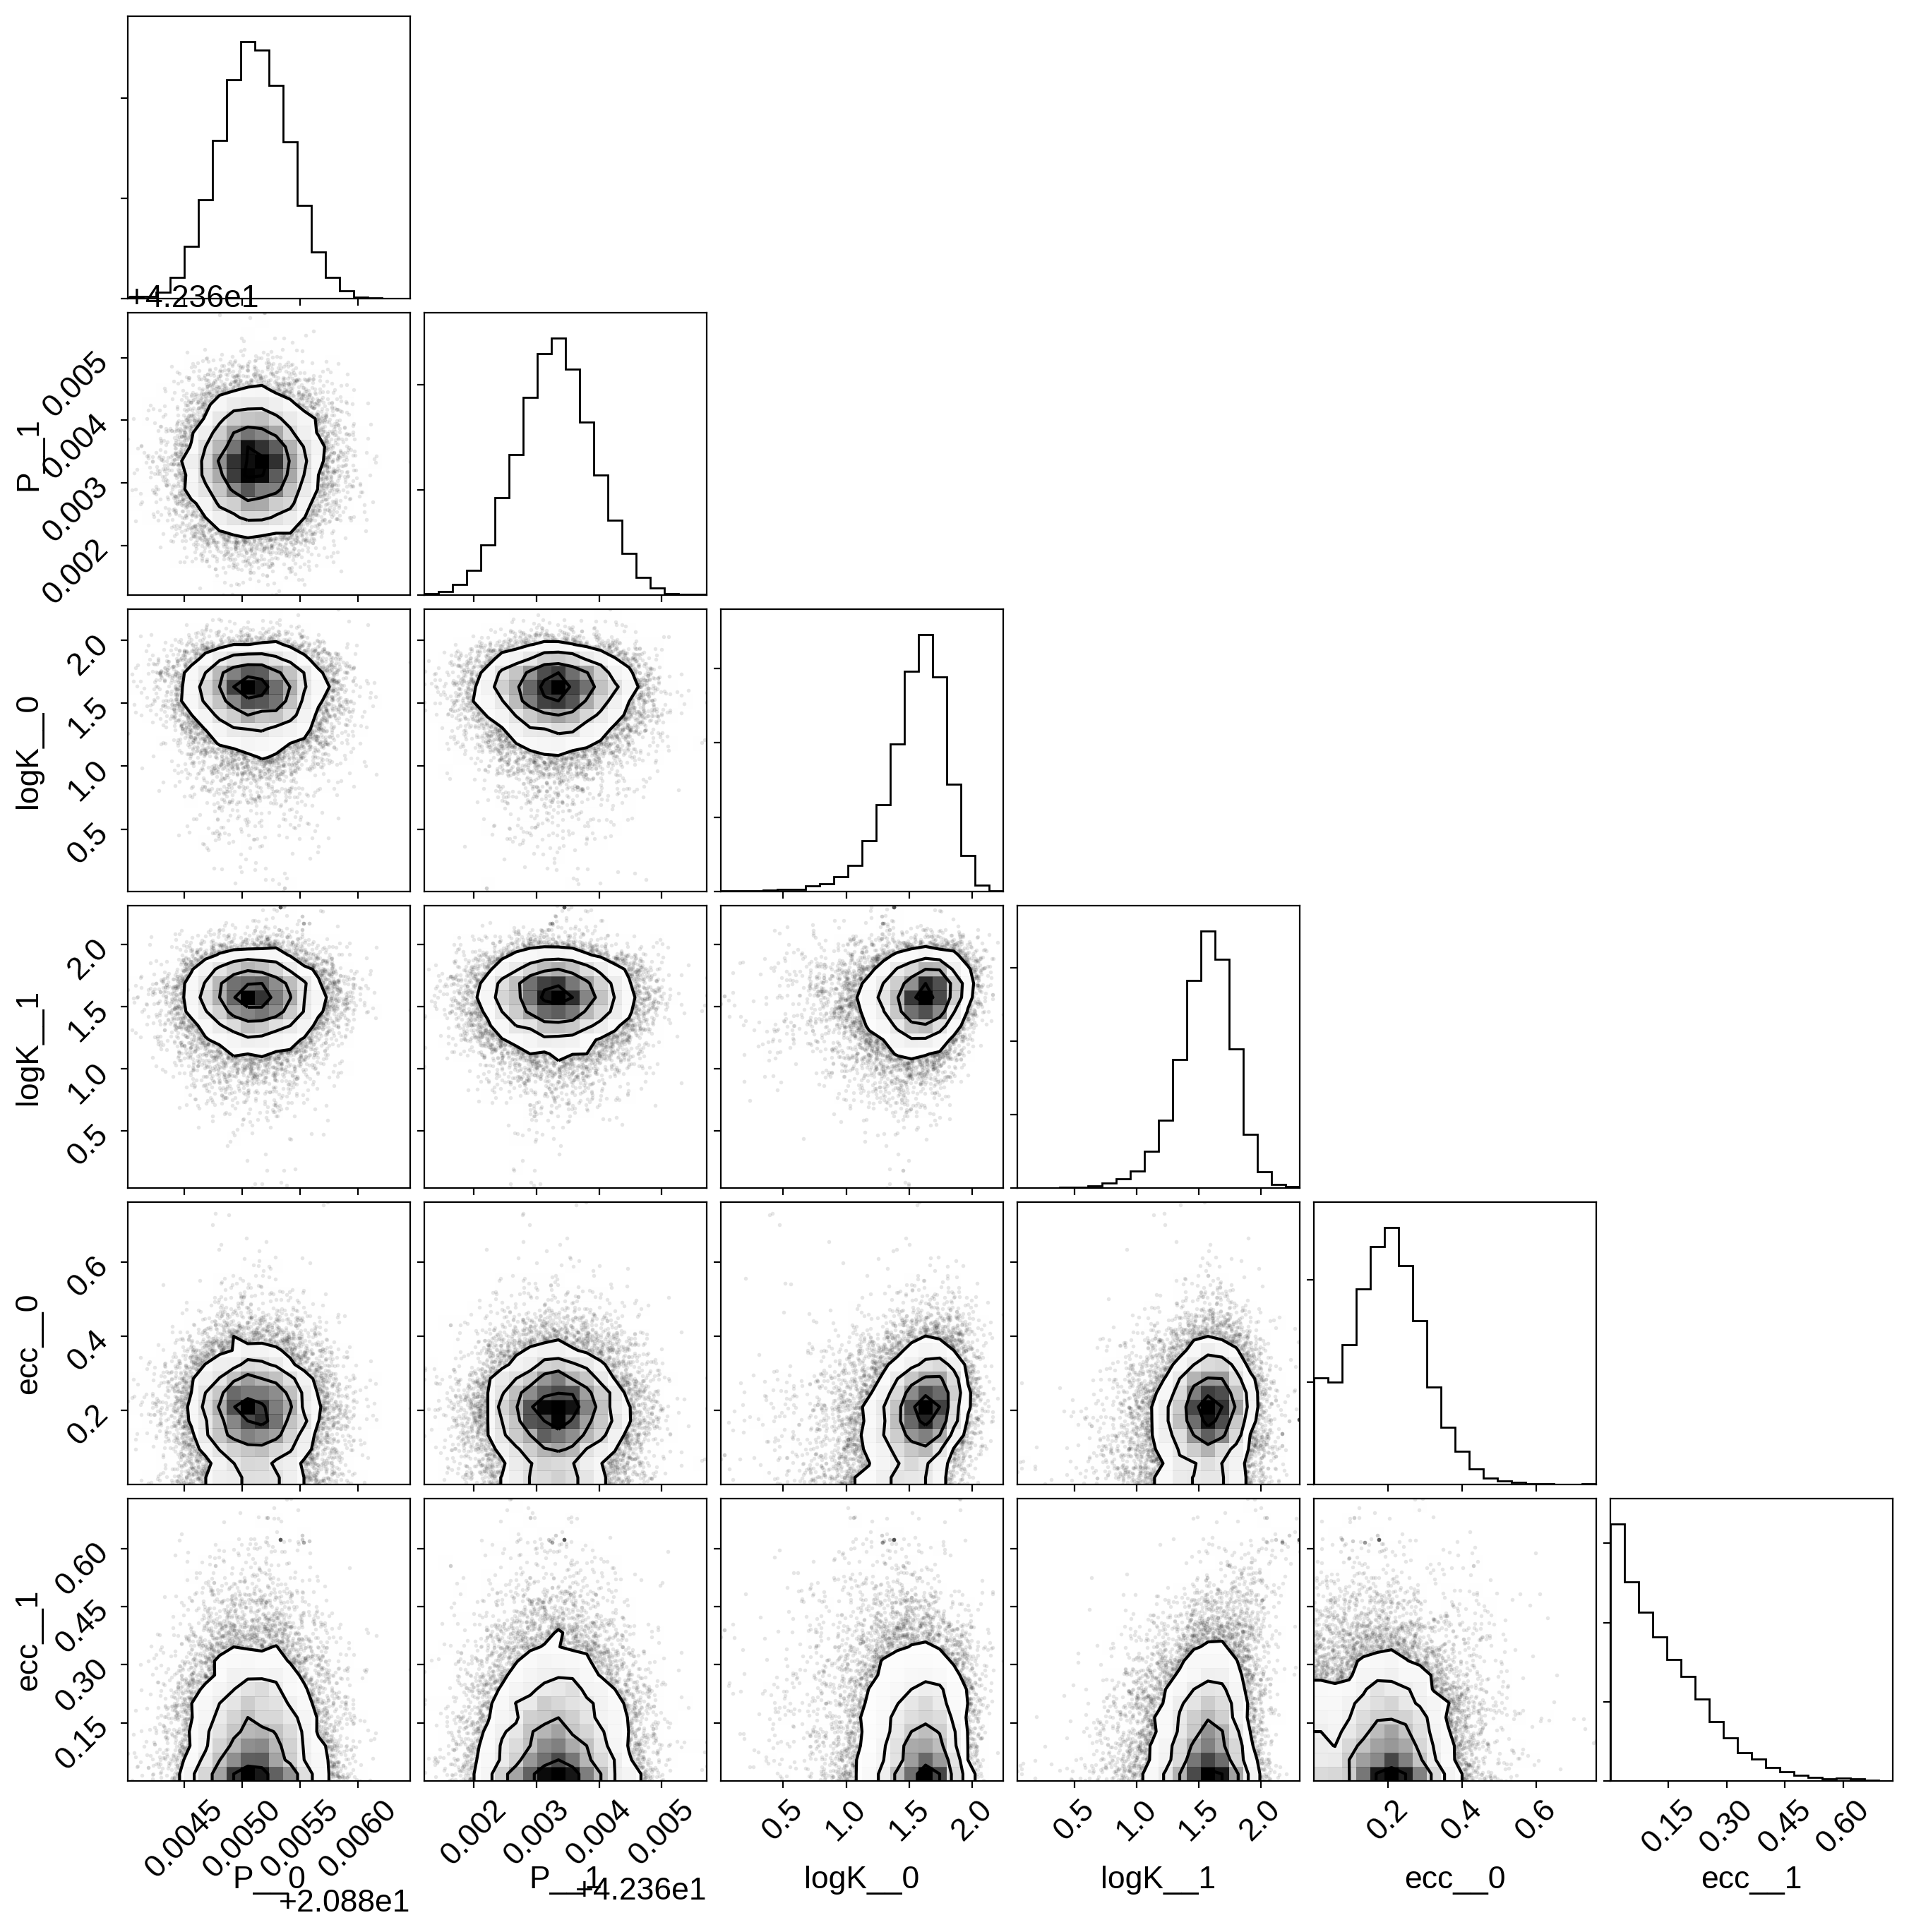

In [13]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=["P", "logK", "ecc"])
corner.corner(samples);

Finally, let's plot the plosterior constraints on the RV model and compare those to the data:

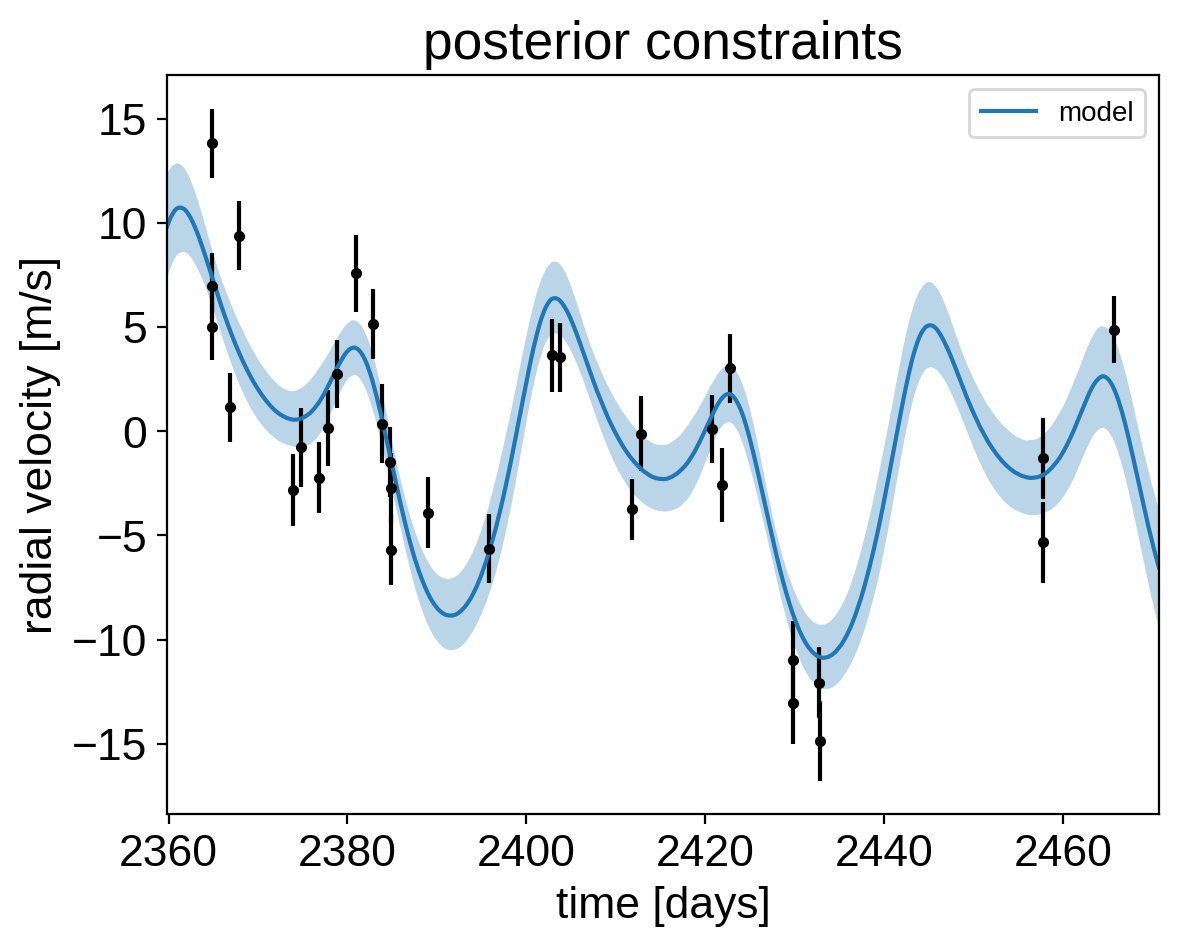

In [14]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

# Compute the posterior predictions for the RV model
pred = np.percentile(trace["rv_model_pred"], [16, 50, 84], axis=0)
plt.plot(t, pred[1], color="C0", label="model")
art = plt.fill_between(t, pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("posterior constraints");

## Phase plots

It might be also be interesting to look at the phased plots for this system.
Here we'll fold the dataset on the median of posterior period and then overplot the posterior constraint on the folded model orbits.

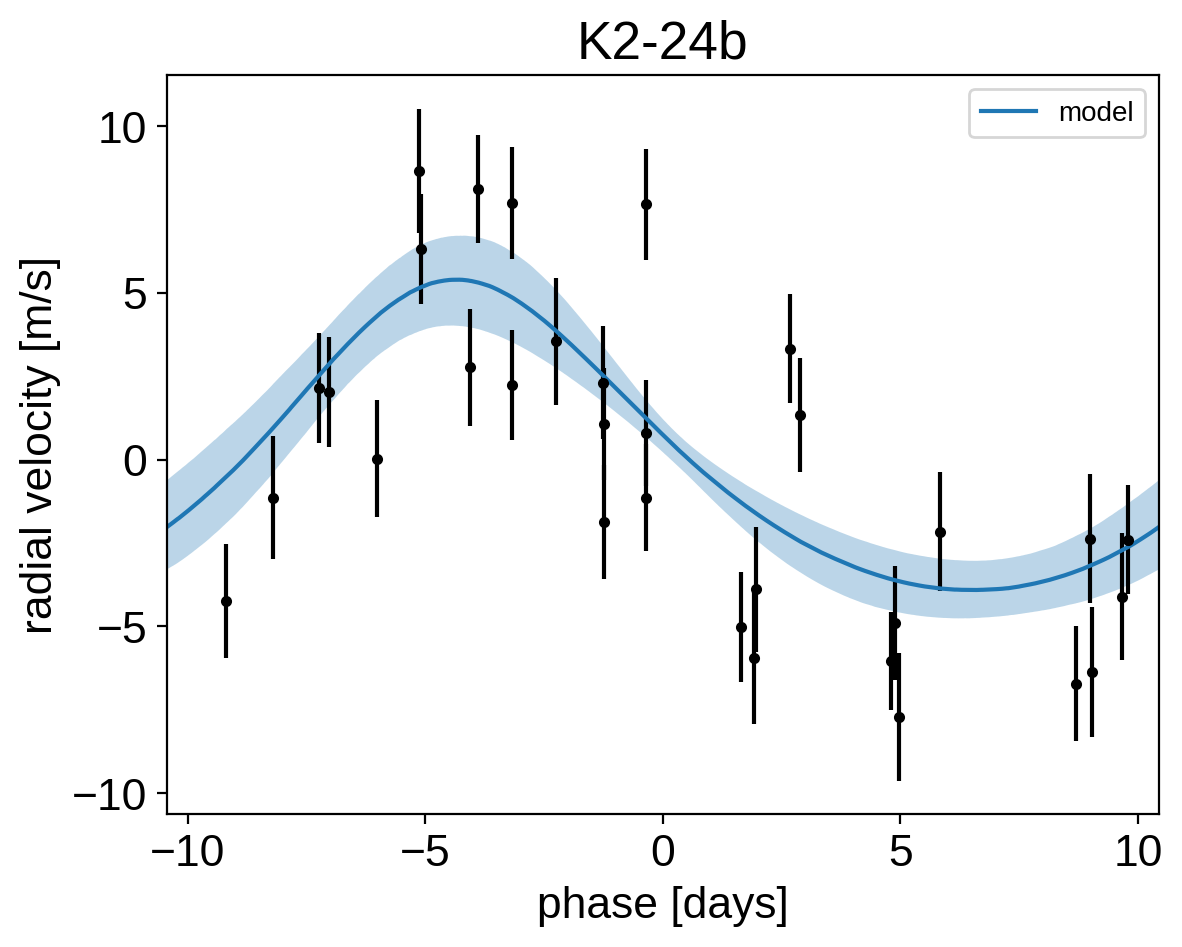

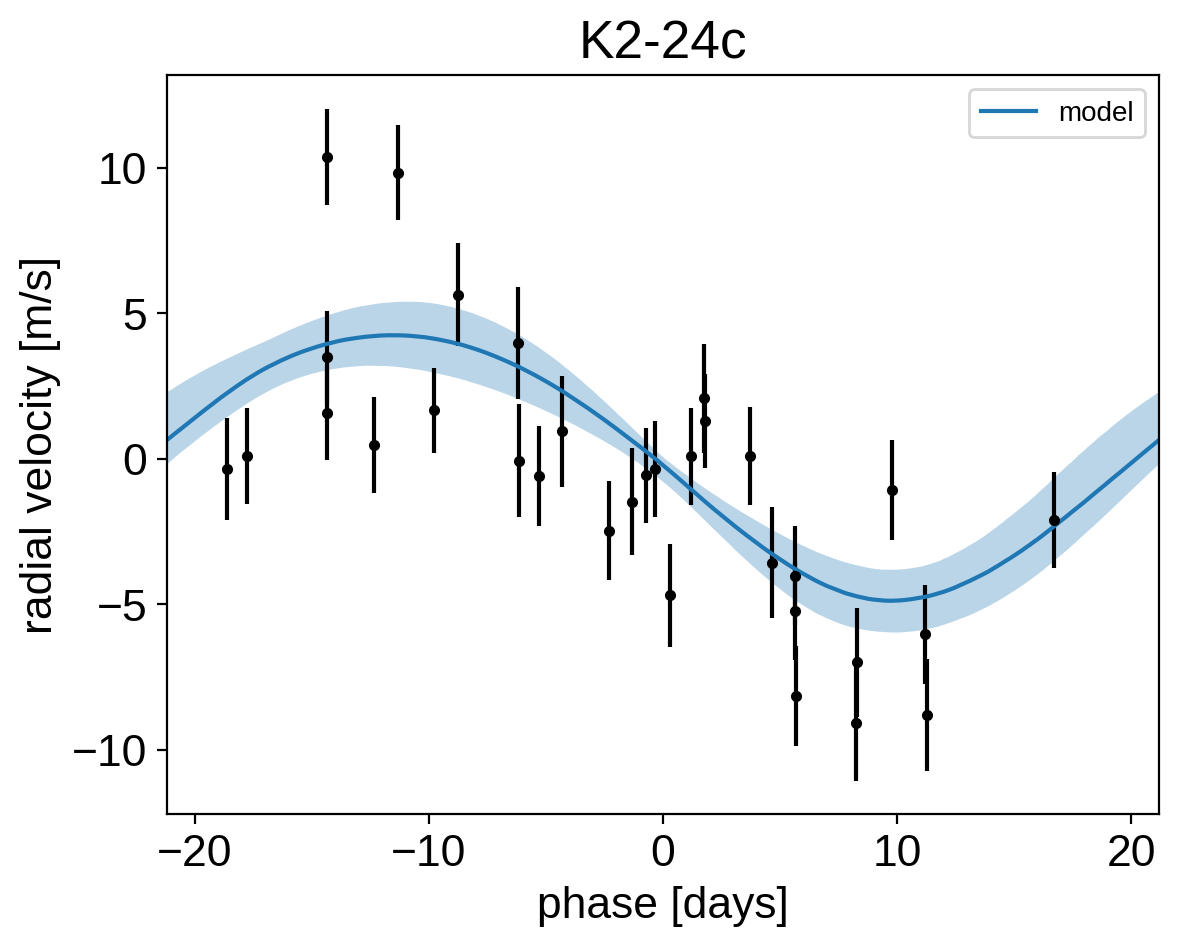

In [15]:
for n, letter in enumerate("bc"):    
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["P"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x - t0 + 0.5*p) % p - 0.5*p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k")
    
    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t - t0 + 0.5*p) % p - 0.5*p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C0", label="model")
    art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C0", alpha=0.3)
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter));

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [16]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:pymc3, exoplanet:theano}.


In [17]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.6},
   month = apr,
    year = 2019,
     doi = {10.5281/zenodo.2651251},
     url = {https://doi.org/10.5281/zenodo.2651251}
...
